# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('sample1.txt', 'sample2.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ⌴1   109  ⌴  1  -  -  0.000209
1        1.     6  1  .  -  -  0.000012
2        .⌴  4405  .  ⌴  -  -  0.008464
3        ⌴а   926  ⌴  а  -  v  0.001779
4        ав  1334  а  в  v  c  0.002563
...     ...   ... .. .. .. ..       ...
1506     pe     1  p  e  -  -  0.000002
1507     en     1  e  n  -  -  0.000002
1508     ny     1  n  y  -  -  0.000002
1509     yг     1  y  г  -  c  0.000002
1510     гy     1  г  y  c  -  0.000002

[1511 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   40737
е   34625
а   31599
и   23548
т   22926
н   19172
л   17292
р   16091
с   14124
в   10986
к   10258
м    9608
у    9586
д    8850
ь    8141
я    7680
ы    7016
й    5217
г    5049
з    5012
ч    4510
б    3839
ж    3461
ш    2968
п    2937
х    2785
ю    2572
щ    1361
ц    1139
ф     397
ъ     105
э      79
ё       1

freq_out     freq_in       outer   frequency     outerness
ъ    1.940598    0.000000   -1.940598    1.940598 -10000.000000
ь   11.662805    0.326635  -11.336169   11.989440  -9455.128205
ы   28.667059    2.382517  -26.284542   31.049576  -8465.346535
а   73.127899   16.523908  -56.603991   89.651807  -6313.759108
п  132.075979   38.312409  -93.763570  170.388389  -5502.931890
и   67.882519   32.663539  -35.218980  100.546058  -3502.770877
у   23.095043   12.950132  -10.144911   36.045176  -2814.498934
о   97.414201   83.791584  -13.622617  181.205784   -751.776058
э    0.883837    1.018334    0.134497    1.902171    707.070707
е   53.760342  118.683928   64.923587  172.444270   3764.902507
я    6.186858   56.680846   50.493988   62.867705   8031.784841
ю    0.480346   33.739514   33.259168   34.219860   9719.258843
й    0.134497  100.238636  100.104139  100.373133   9973.200613

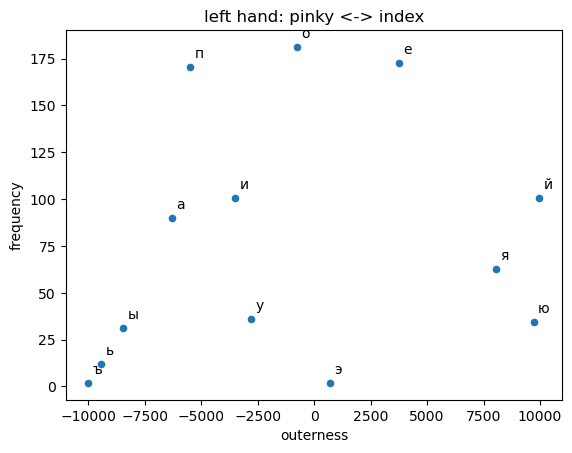

In [5]:
CORP.display_outerness("(t1 == 'v' | l1 == 'й' | l1 == 'п') & (t2 == 'v' | l2 == 'й' | l2 == 'п')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency     outerness
ц    1.114403    8.358023   -7.243620    9.472426  -7647.058824
р   43.980494  153.345707 -109.365213  197.326201  -5542.356378
щ    0.979906    3.343209   -2.363303    4.323115  -5466.666667
л   24.958786   79.718248  -54.759462  104.677034  -5231.277533
н   51.954240  155.997218 -104.042978  207.951458  -5003.233854
к   34.623351   77.201234  -42.577883  111.824585  -3807.560137
т   90.727782  159.148289  -68.420507  249.876071  -2738.177624
м   19.790262   19.963186   -0.172925   39.753448    -43.499275
в   68.766356   65.327077    3.439278  134.093433    256.483737
д   53.222354   39.964800   13.257554   93.187154   1422.680412
ш   15.909065   11.105603    4.803462   27.014668   1778.093883
х    7.781608    4.880317    2.901291   12.661925   2291.350531
ф    1.633177    0.768554    0.864623    2.401731   3600.000000
г   28.263568   12.719566   15.544002   40.983134   3792.780122
с  232.084049   80.544444  151.539606  312.628493   4847.274292
ж   19.002494    6.186858   12.815635   25.189352   5087.719298
ч   40.675713   12.757994   27.917719   53.433706   5224.739302
п   74.818717   18.599003   56.219714   93.417721   6018.099548
б   26.726460    4.630537   22.095923   31.356997   7046.568627
з   61.676447    4.342329   57.334117   66.018776   8684.516880
й   20.212966    0.000000   20.212966   20.212966  10000.000000

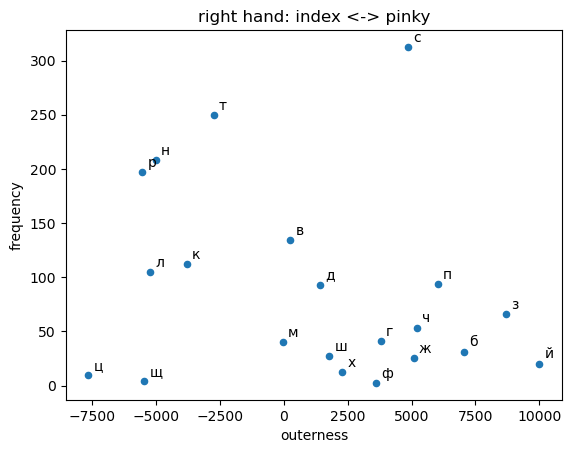

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
8642226 622246
6421134 431124
 400002 200002
 211114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    'optozorax': # 2021 https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап   ролджэ
'ячсиы∅ ,шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ $∅∅∅∅∅∅
&∅∅∅∅∅   ∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап   ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест33эрго': 
(r''' 
ъ123456 7890-=/
шщфыхэ∅ ∅жмвкзч
=аоией   ,ртнсд
∅ьуюяё∅ ∅цлбпг∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   .∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.8207
key "?" repeated: 2
key """ repeated: 2
layout usphonetic: 2.9978
layout rusdvorak: 1.5965
key ":" repeated: 2
layout диктор: 1.3714
layout зубачёв: 1.3597
key "." repeated: 2
layout скоропис: 1.3416
key ":" repeated: 2
key ";" repeated: 2
key """ repeated: 3
layout ант: 1.5849
layout ugnvs: 1.8168
layout леонов: 1.2141
layout леонов2: 1.0692
layout леонов3: 1.3102
key "." repeated: 2
layout optozorax: 2.017
layout ergodox: 2.8188
layout тест1: 2.5539
layout тест2: 2.2841
layout тест3: 1.9403
layout тест4: 1.6877
layout тест5: 1.5559
layout тест6: 1.6013
layout тест7: 1.6131
layout тест8: 1.564
layout тест9: 1.5749
layout тест10: 1.5379
layout тест11: 1.5757
layout тест12: 1.4432
layout тест13: 1.4514
layout тест14: 1.387
layout тест15: 1.2982
layout тест16: 1.2912
layout тест17: 1.2483
layout тест18: 1.2595
layout тест19: 1.2698
layout тест20: 1.2635
layout тест21: 1.213
layout тест22: 1.213
layout тест23: 1.1977
layout тест24: 1.1758
layout тест25: 1.1966
layout

# Final Standings <a name="standings">

In [48]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест34', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

print('\nErgodox league:\n')
chosen_kbd = [
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест33эрго', 'My best layout minimally adapted to Ergodox'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# how well I am against Leonov's layout (the best of eariler authors' layouts)
print('\nimprovement over Leonov\'s layout', round(1 - results['тест31'].score / results['леонов'].score, 3))

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.94  | Alien #2, many counterparts on AltGr   |
| тест34     |   1.12  | Best and currently in use on my laptop |
| ино1       |   1.126 | Alien #1, rare letters on AltGr        |
| леонов     |   1.214 | Leonov                                 |
| скоропис   |   1.342 | Skoropis                               |
| зубачёв    |   1.36  | Zubachov                               |
| диктор     |   1.371 | Dictor                                 |
| тест10     |   1.538 | First optimized after hand testing     |
| тест9      |   1.575 | First hand-tested                      |
| ант        |   1.585 | ANT                                    |
| rusdvorak  |   1.596 | Dvorak translit                        |
| ugnvs      |   1.817 | UGNVS                                  |
| тест2      |   2.284 | My first Dvorak analog  

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

In [13]:
lyt = Layout('тест37', (r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсг¶
 ьуюяё цлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

тест37 : 1.119 


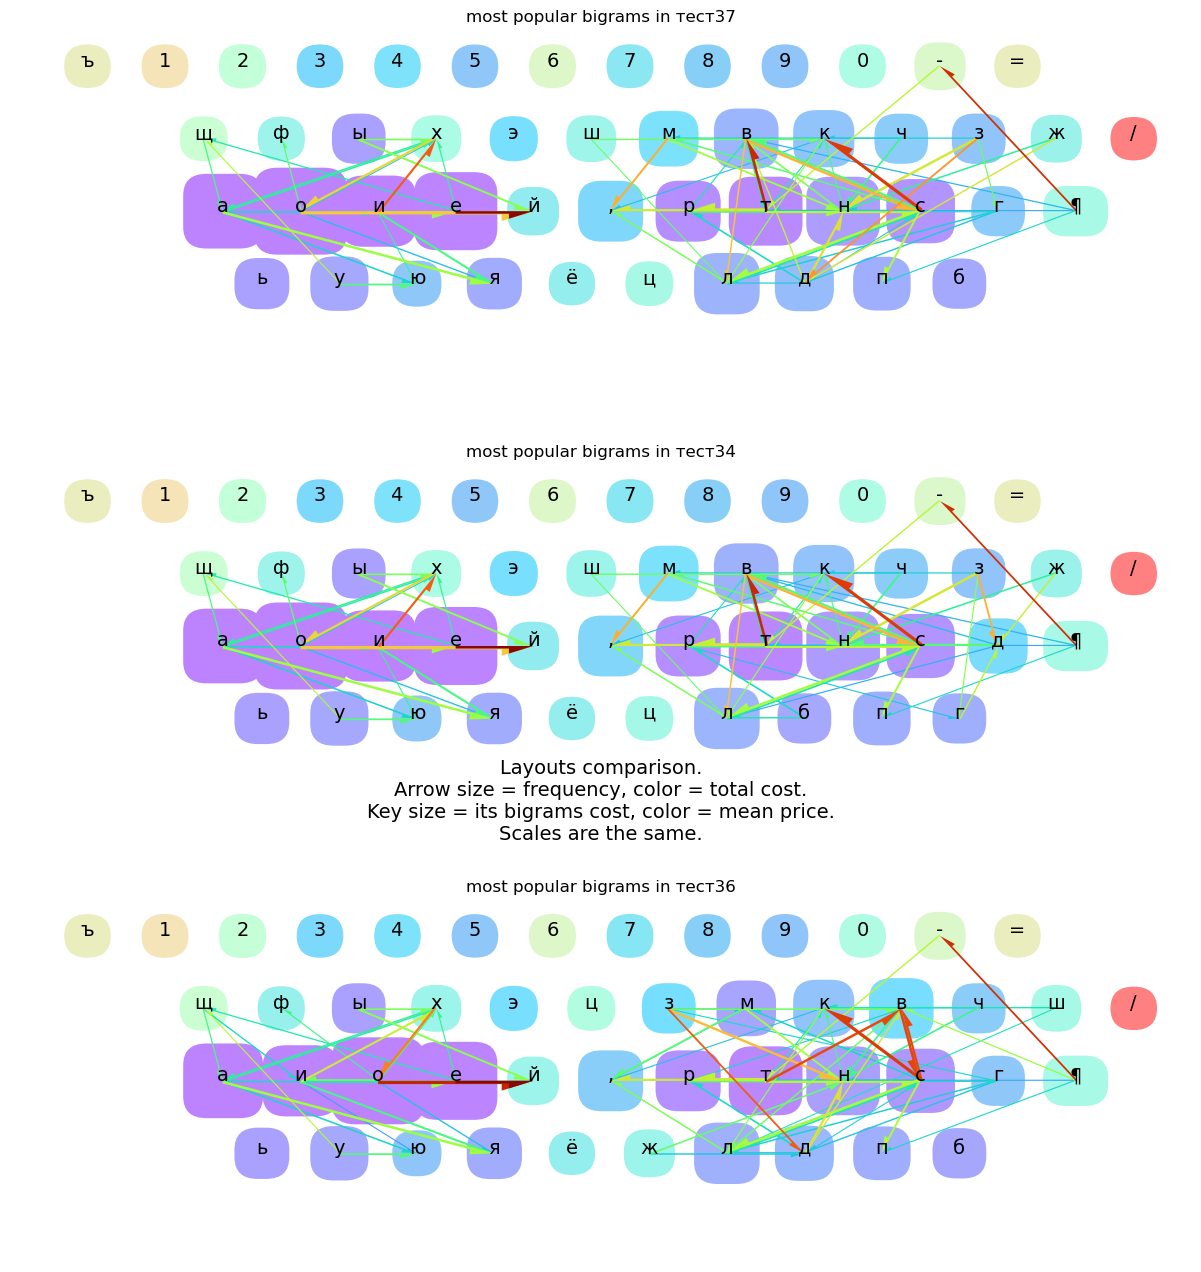

In [14]:
r.combomap(results['тест34'], results['тест36'])

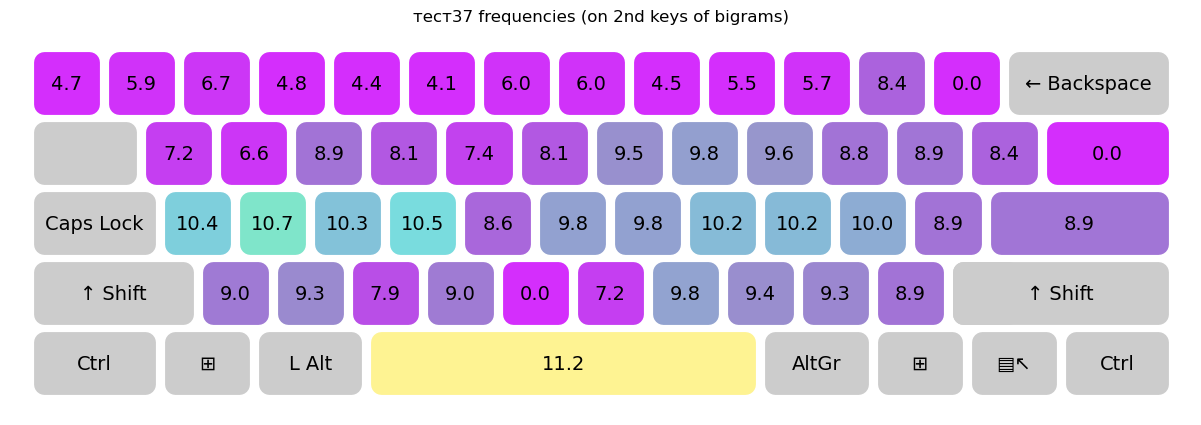

In [15]:
results['тест37'].display('num')

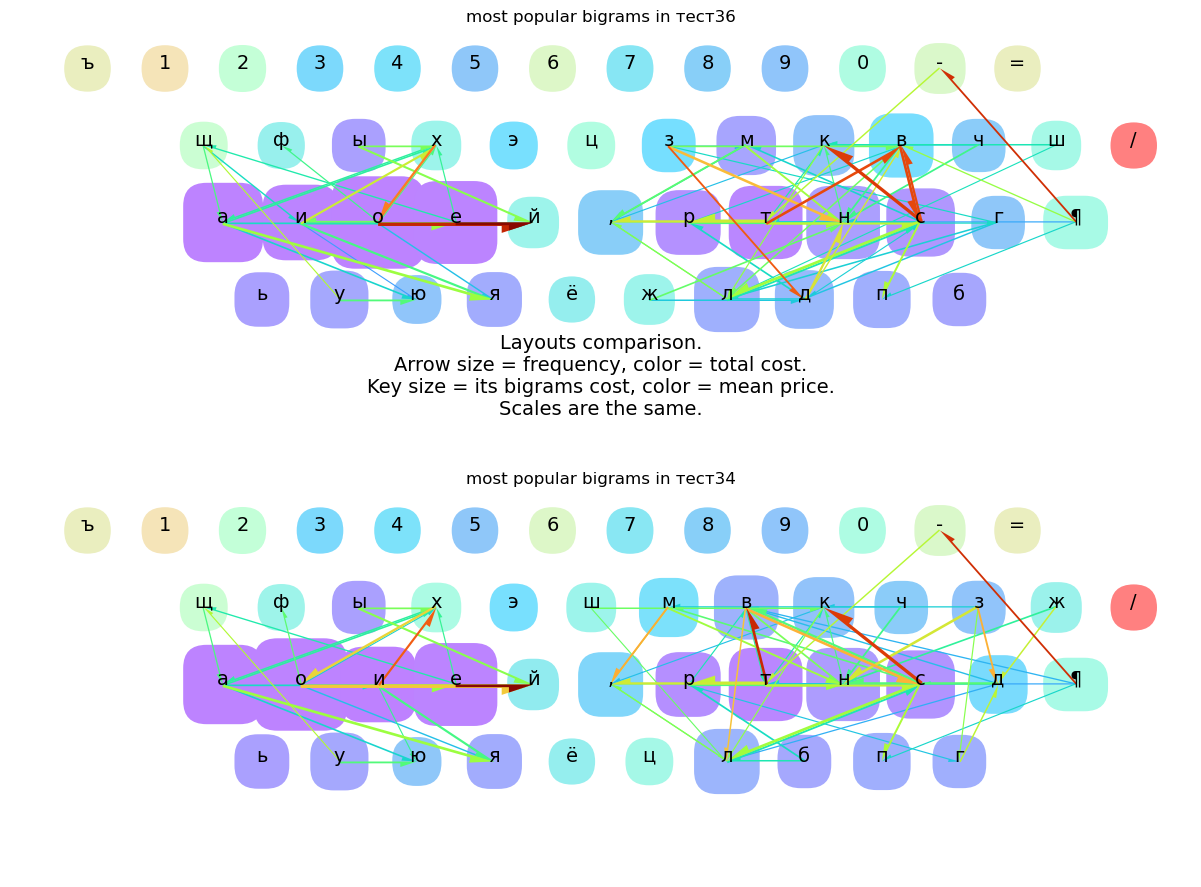

In [16]:
results['тест36'].combomap(results['тест34'])

In [17]:
results['тест34'].compare(results['тест36']).sort_values('delta', ascending=False).head(30)

bigram   num                     category_old  price_old  cost_old  \
106     ⌴в  6392                        space bar          1      6392   
19      св   865       in, over 1 finger, adj row          2      1730   
154     ой  2056      in, over 1 finger, same row          2      4112   
42      ов  3474                     altern hands          1      3474   
616     дв   329       in, over 1 finger, adj row          2       658   
302     ое  1222      in, over 1 finger, same row          0         0   
134     вс  1158             out, over one finger          4      4632   
100     ⌴з  2082                        space bar          2      4164   
77      ⌴г  1914                        space bar          1      1914   
95      хо   954             out, over one finger          4      3816   
156     ог  1841                     altern hands          1      1841   
410     ¶в   295       in, over 1 finger, adj row          2       590   
377     зд   589              same finger adj row          8      4712   
208     дн   879  in, adj finger, same or adj row          2      1758   
220     аз  1594                     altern hands          2      3188   
25      зв   498      in, over 1 finger, same row          1       498   
209     ег  1360                     altern hands          1      1360   
4       ав  1334                     altern hands          1      1334   
24      из  1281                     altern hands          2      2562   
515     дк   172          pinky -> ring, next row          4       688   
137     ив  1172                     altern hands          1      1172   
88      зн  1115          pinky -> ring, next row          3      3345   
556     дц   112       in, over 1 finger, adj row          5       560   
21      ои   500  in, adj finger, same or adj row          2      1000   
388     др   490      in, over 1 finger, same row          0         0   
111     ою   170                    in, lower row          2       340   
303     ох   212  in, adj finger, same or adj row          4       848   
87      ез   822                     altern hands          2      1644   
438     вш   196  in, adj finger, same or adj row          6      1176   
367     оз   759                     altern hands          2      1518   

                        category_new  price_new  cost_new  delta  
106                        space bar          2     12784   6392  
19               same finger adj row          8      6920   5190  
154  in, adj finger, same or adj row          4      8224   4112  
42                      altern hands          2      6948   3474  
616        over 1 finger, over 1 row         10      3290   2632  
302  in, adj finger, same or adj row          2      2444   2444  
134              same finger adj row          6      6948   2316  
100                        space bar          3      6246   2082  
77                         space bar          2      3828   1914  
95               same finger adj row          6      5724   1908  
156                     altern hands          2      3682   1841  
410              same finger adj row          8      2360   1770  
377              adj finger over row         11      6479   1767  
208             out, over one finger          4      3516   1758  
220                     altern hands          3      4782   1594  
25                    index -> pinky          4      1992   1494  
209                     altern hands          2      2720   1360  
4                       altern hands          2      2668   1334  
24                      altern hands          3      3843   1281  
515              adj finger over row         11      1892   1204  
137                     altern hands          2      2344   1172  
88              out, over one finger          4      4460   1115  
556              adj finger over row         14      1568   1008  
21              out, over one finger          4      2000   1000  
388  in, adj finger, same or adj r

In [18]:
results['тест36'].bigrams[results['тест36'].bigrams.bigram == 'ом']

bigram   num l1 l2 t1 t2      freq  price_l2  price_di      category  \
46     ом  2395  о  м  v  c  0.004602         1         0  altern hands   

    price  cost  finger  column  row   h1   h2  
46      1  2395     7.0     9.0  1.0  0.0  1.0

In [19]:
results['тест34'].layout.keymap.loc['м']

layer        0
row          1
column       8
key_count    1
finger       6
ftype        1
hand         1
penalty      3
Name: м, dtype: int64

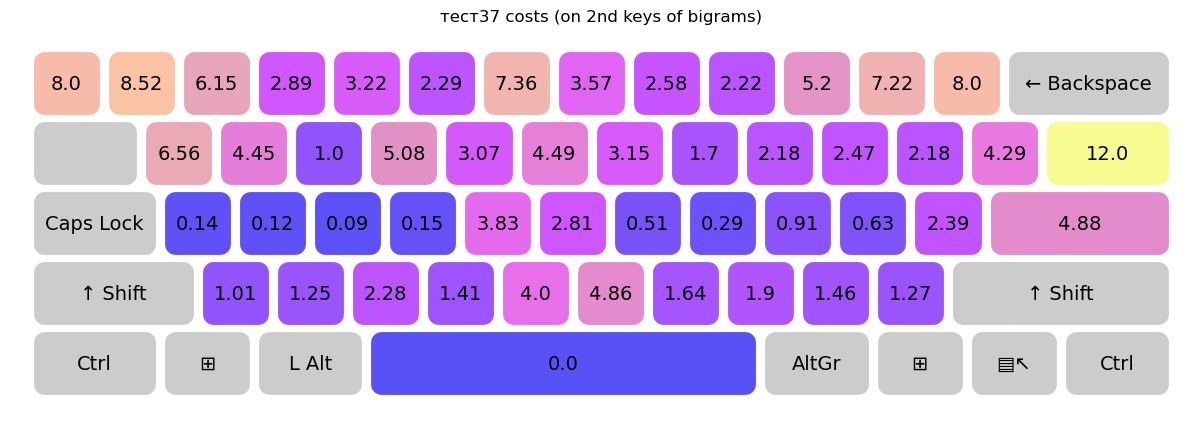

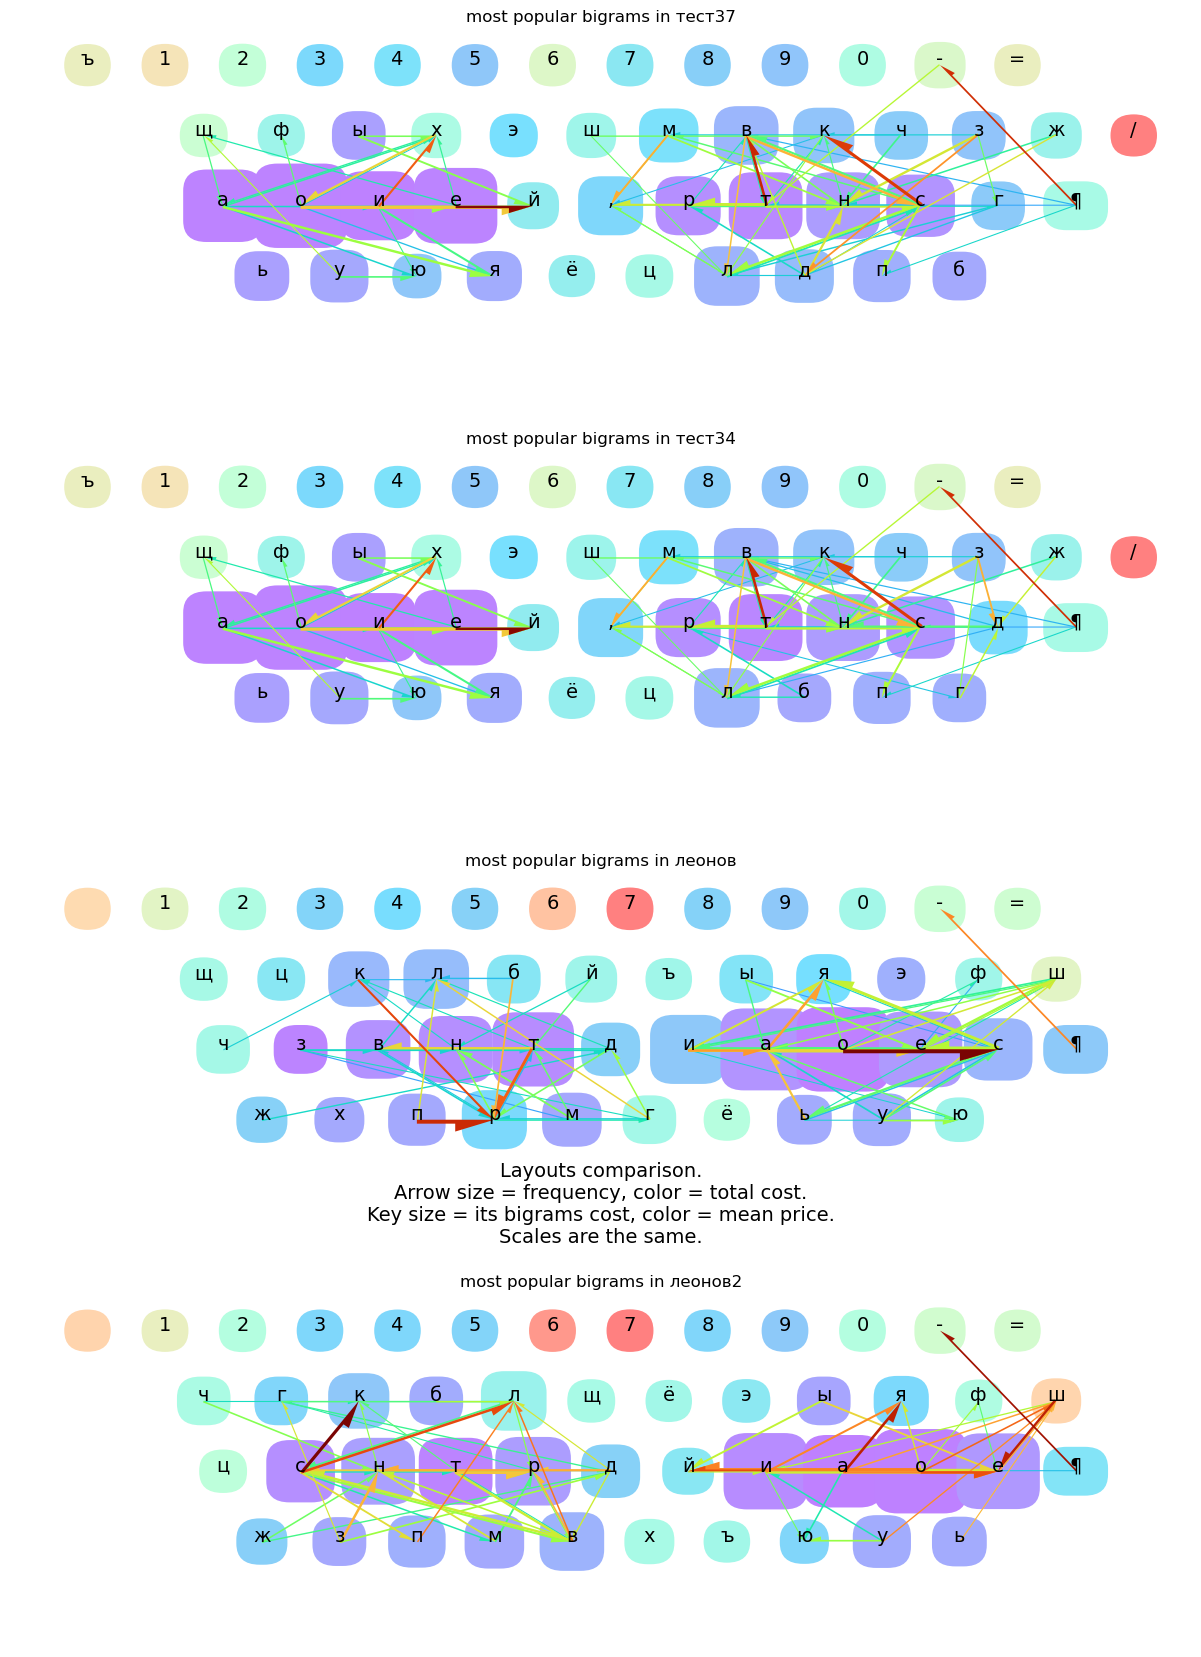

In [20]:
r.display('cost')
r.combomap(results['тест34'], results['леонов'], results['леонов2'])

       cost     num
h2                 
0.0  133158  271637
1.0  449704  248534


<AxesSubplot: xlabel='finger'>

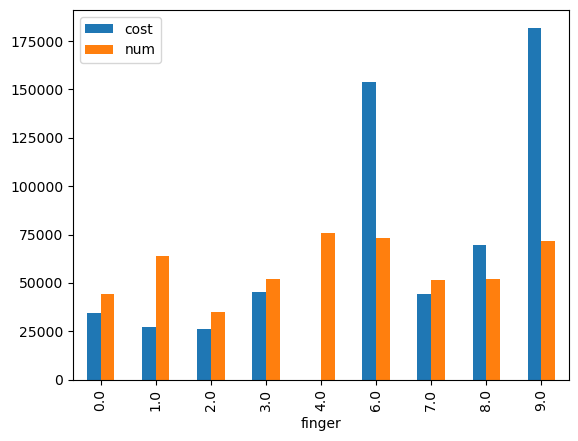

In [21]:
print(results['тест34'].bigrams.groupby('h2').agg({'cost': 'sum', 'num': 'sum'}))
results['тест34'].bigrams.groupby('finger').agg({'cost': 'sum', 'num': 'sum'}).plot.bar()

       cost     num
h2                 
0.0  133158  271637
1.0  449215  248534


<AxesSubplot: xlabel='finger'>

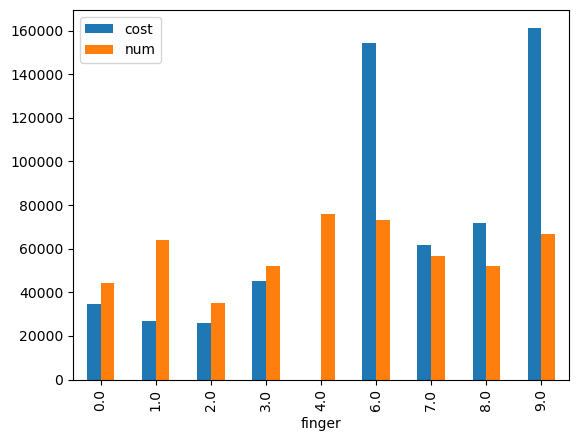

In [22]:
print(r.bigrams.groupby('h2').agg({'cost': 'sum', 'num': 'sum'}))
r.bigrams.groupby('finger').agg({'cost': 'sum', 'num': 'sum'}).plot.bar()

In [23]:
r.bigrams[r.bigrams.bigram=='по']

bigram   num l1 l2 t1 t2      freq  price_l2  price_di      category  \
41     по  3978  п  о  c  v  0.007643         0         0  altern hands   

    price  cost  finger  column  row   h1   h2  
41      0     0     1.0     2.0  2.0  1.0  0.0

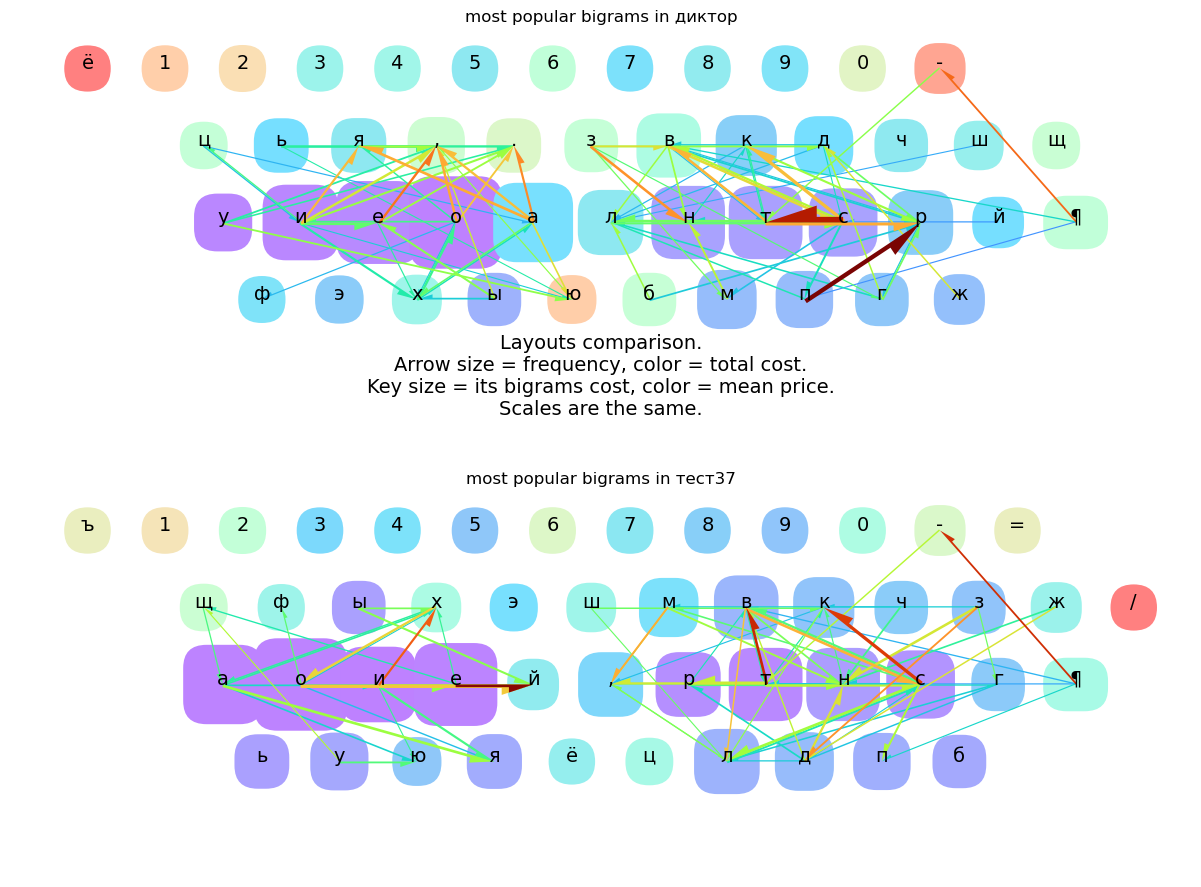

In [24]:
results['диктор'].combomap(r)

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

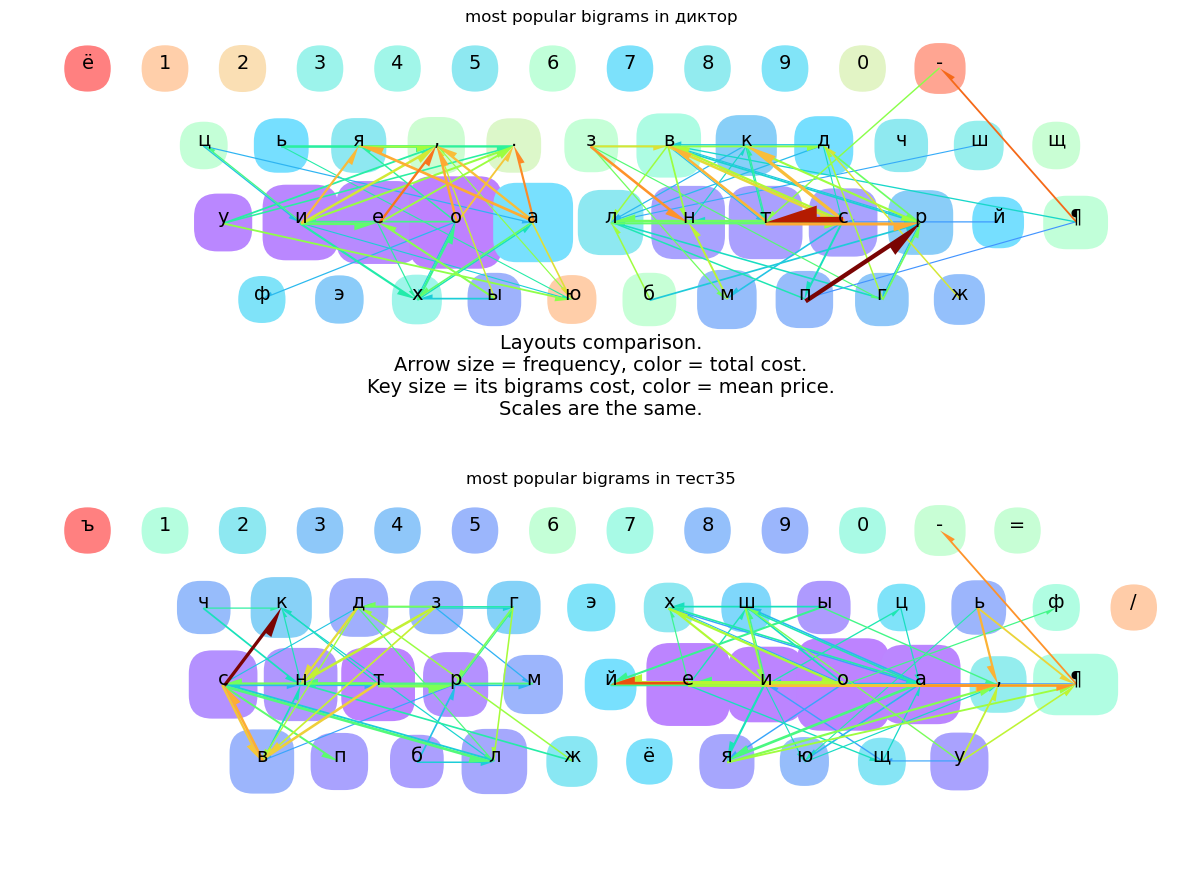

In [25]:
results['диктор'].combomap(results['тест35'])

## Losses

In [26]:
compare(results, 'тест32', 'тест33').head(30)

bigram   num                     category_old  price_old  cost_old  \
91      ⌴м  3054                        space bar          1      3054   
46      ом  2395                     altern hands          1      2395   
72      ем  1971                     altern hands          1      1971   
10      пр  3190                     altern hands          0         0   
205     им  1435                     altern hands          1      1435   
80      ам  1305                     altern hands          1      1305   
47      м,   599  in, adj finger, same or adj row          4      2396   
256     их   798             out, over one finger          5      3990   
141     сп   663                     altern hands          1       663   
365     ущ   228                     altern hands          4       912   
290     ща   274                     altern hands          0         0   
142     м.   380  in, adj finger, same or adj row          4      1520   
271     оф   259                    in, lower row          2       518   
493     ум   586                     altern hands          1       586   
117     ую   572      in, over 1 finger, same row          1       572   
132     ым   538                     altern hands          1       538   
181     ию   209                    in, lower row          2       418   
482     мл   162  in, adj finger, same or adj row          3       486   
406     см   447       in, over 1 finger, adj row          2       894   
485     бл   391      in, over 1 finger, same row          1       391   
540     хи   155                    in, lower row          1       155   
252     ющ   124                     altern hands          4       496   
374     ях   106             out, over one finger          5       530   
452     ¶п   230                     altern hands          1       230   
366     ще   645                     altern hands          0         0   
574     вп    63                     altern hands          1        63   
334     ⌴х   620                        space bar          1       620   
522     яе   121                    in, lower row          1       121   
438     вш   196  in, adj finger, same or adj row          5       980   
419     ащ   141                     altern hands          4       564   

                        category_new  price_new  cost_new  delta  
91                         space bar          3      9162   6108  
46                      altern hands          3      7185   4790  
72                      altern hands          3      5913   3942  
10        in, over 1 finger, adj row          1      3190   3190  
205                     altern hands          3      4305   2870  
80                      altern hands          3      3915   2610  
47               same finger adj row          8      4792   2396  
256              same finger adj row          8      6384   2394  
141          pinky -> ring, next row          4      2652   1989  
365              adj finger over row         12      2736   1824  
290              same finger adj row          6      1644   1644  
142              same finger adj row          8      3040   1520  
271          ring -> pinky, next row          7      1813   1295  
493                     altern hands          3      1758   1172  
117  in, adj finger, same or adj row          3      1716   1144  
132                     altern hands          3      1614   1076  
181              same finger adj row          7      1463   1045  
482             same finger over row          9      1458    972  
406       in, over 1 finger, adj row          4      1788    894  
485  in, adj finger, same or adj row          3      1173    782  
540              same finger adj row          6       930    775  
252        over 1 finger, over 1 row         10      1240    744  
374              adj finger over row         12      1272    742  
452          pinky -> ring, next row          4       920    690  
366       in, over 1 finger, adj r

## Gains

In [27]:
compare(results, 'тест32', 'тест33').tail(30)

bigram   num                     category_old  price_old  cost_old  \
480     яю    81              adj finger over row         11       891   
398     ⌴я   733                        space bar          2      1466   
455     фи   147              same finger adj row          6       882   
417     ля   777                     altern hands          2      1554   
647     шк   389             out, over one finger          5      1945   
415     еп   393                   index -> pinky          3      1179   
409     ью   203        pinky -> index over 1 row          5      1015   
217     пу   416  in, adj finger, same or adj row          3      1248   
582     шл   214             same finger over row          9      1926   
162     пе   937       in, over 1 finger, adj row          1       937   
360     вы  1023                     altern hands          2      2046   
557     пя   119        over 1 finger, over 1 row         10      1190   
546     пы   124             same finger over row         10      1240   
285     сь  1119                     altern hands          2      2238   
301     ая  1210       in, over 1 finger, adj row          3      3630   
575     бщ   106              adj finger over row         14      1484   
173     уп   354             out, over one finger          5      1770   
274     бы  1454                     altern hands          2      2908   
176     ⌴э  1457                        space bar          4      5828   
424     зм   277        over 1 finger, over 1 row          9      2493   
75      ны  1744                     altern hands          2      3488   
207     ся  1824                     altern hands          2      3648   
95      хо   954              same finger adj row          6      5724   
138     ль  2227                     altern hands          2      4454   
253     ап   399              same finger adj row          7      2793   
312     оп   588          ring -> pinky, next row          6      3528   
39      ть  3088                     altern hands          2      6176   
174     па   643              same finger adj row          6      3858   
30      ия   810              same finger adj row          8      6480   
41      по  3978          pinky -> ring, next row          3     11934   

                        category_new  price_new  cost_new  delta  
480           index->middle same row          2       162   -729  
398                        space bar          1       733   -733  
455       in, over 1 finger, adj row          1       147   -735  
417                     altern hands          1       777   -777  
647  in, adj finger, same or adj row          3      1167   -778  
415                     altern hands          1       393   -786  
409      in, over 1 finger, same row          1       203   -812  
217                     altern hands          1       416   -832  
582        pinky -> index over 1 row          5      1070   -856  
162                     altern hands          0         0   -937  
360                     altern hands          1      1023  -1023  
557                     altern hands          1       119  -1071  
546                     altern hands          1       124  -1116  
285                     altern hands          1      1119  -1119  
301       in, over 1 finger, adj row          2      2420  -1210  
575                     altern hands          2       212  -1272  
173                     altern hands          1       354  -1416  
274                     altern hands          1      1454  -1454  
176                        space bar          3      4371  -1457  
424      in, over 1 finger, same row          3       831  -1662  
75                      altern hands          1      1744  -1744  
207                     altern hands          1      1824  -1824  
95              out, over one finger          4      3816  -1908  
138                     altern hands          1      2227  -2227  
253                     altern han

You can save the comparison table to CSV:

In [28]:
compare(results, 'леонов', 'тест33').to_csv('leonov-test33.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [29]:
results['тест33'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram   num l1 l2 t1 t2      freq  price_l2  price_di  \
143      .¶  2835  .  ¶  -  -  0.005447         4         2   
32       ¶¶  3769  ¶  ¶  -  -  0.007242         4         0   
1314     --  1687  -  -  -  -  0.003241         6         0   
98       ей  1219  е  й  v  c  0.002342         2         6   
91       ⌴м  3054  ⌴  м  -  c  0.005868         3         0   
390      ⌴-  1382  ⌴  -  -  -  0.002655         6         0   
259      тв  1155  т  в  c  c  0.002219         1         6   
726      ¶-   555  ¶  -  -  -  0.001066         6         8   
9        ⌴п  7530  ⌴  п  -  c  0.014468         1         0   
59       ск  1841  с  к  c  c  0.003537         1         3   
46       ом  2395  о  м  v  c  0.004602         3         0   
153      ⌴д  3303  ⌴  д  -  c  0.006346         2         0   
106      ⌴в  6392  ⌴  в  -  c  0.012281         1         0   
256      их   798  и  х  v  c  0.001533         2         6   
72       ем  1971  е  м  v  c  0.003787         3         0   
53       од  2499  о  д  v  c  0.004802         2         0   
47       м,   599  м  ,  c  -  0.001151         2         6   
63       ⌴ч  2361  ⌴  ч  -  c  0.004536         2         0   
377      зд   589  з  д  c  c  0.001132         2         6   
134      вс  1158  в  с  c  c  0.002225         0         4   
176      ⌴э  1457  ⌴  э  -  v  0.002799         3         0   
203      ож  1086  о  ж  v  c  0.002087         4         0   
205      им  1435  и  м  v  c  0.002757         3         0   
442      вл   391  в  л  c  c  0.000751         1        10   
100      ⌴з  2082  ⌴  з  -  c  0.004000         2         0   
154      ой  2056  о  й  v  c  0.003950         2         0   
122      ⌴ж  1013  ⌴  ж  -  c  0.001946         4         0   
49       ⌴к  3927  ⌴  к  -  c  0.007545         1         0   
80       ам  1305  а  м  v  c  0.002507         3         0   
95       хо   954  х  о  c  v  0.001833         0         4   

                         category  price   cost  finger  column  row  
143                index -> pinky      6  17010     9.0    13.0  2.0  
32                       same key      4  15076     9.0    13.0  2.0  
1314                     same key      6  10122     9.0    12.0  0.0  
98            same finger adj row      8   9752     3.0     5.0  2.0  
91                      space bar      3   9162     6.0     8.0  1.0  
390                     space bar      6   8292     9.0    12.0  0.0  
259           same finger adj row      7   8085     7.0     9.0  1.0  
726          same finger over row     14   7770     9.0    12.0  0.0  
9                       space bar      1   7530     8.0    10.0  3.0  
59        pinky -> ring, next row      4   7364     8.0    10.0  1.0  
46                   altern hands      3   7185     6.0     8.0  1.0  
153                     space bar      2   6606     9.0    12.0  2.0  
106                     space bar      1   6392     7.0     9.0  1.0  
256           same finger adj row      8   6384     2.0     4.0  1.0  
72                   altern hands      3   5913     6.0     8.0  1.0  
53                   altern hands      2   4998     9.0    12.0  2.0  
47            same finger adj row      8   4792     6.0     7.0  2.0  
63                      space bar      2   4722     9.0    12.0  1.0  
377           same finger adj row      8   4712     9.0    12.0  2.0  
134          out, over one finger      4   4632     9.0    11.0  2.0  
176                     space bar      3   4371     3.0     5.0  1.0  
203                  altern hands      4   4344     6.0     7.0  1.0  
205                  altern hands      3   4305     6.0     8.0  1.0  
442           adj finger over row     11   4301     6.0     8.0  3.0  
100                     space bar      2   4164     9.0    11.0  1.0  
154   in, over 1 finger, same row      2   4112     3.0     5.0  2.0  
122                     space bar      4   4052     6.0     7.0  1.0  
49                      space bar      1   3927     8.0    10.0

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [30]:
key = 'тест33' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [31]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        8
1      0    0       1          1       0      4     0        6
2      0    0       2          1       0      4     0        4
3      0    0       3          1       0      4     0        2
4      0    0       4          1       1      3     0        2
5      0    0       5          1       2      2     0        2
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        2
0      0    0      11          1       9      4     1        4
-      0    0      12          1       9      4     1        6
=      0    0      13          1       9      4     1        8
→      0    1       0          1       0      4     0        6
щ      0    1       1          1       0      4     0        2
ф      0    1       2          1       0      4     0        2
ы      0    1       3          1       1      3     0        1
х      0    1       4          1       2      2     0        2
э      0    1       5          1       3      1     0        3
ш      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        1
ч      0    1      11          1       9      4     1        2
з      0    1      12          1       9      4     1        2
ж      0    1      13          1       9      4     1        4
/      0    1      14          1       9      4     1        6
а      0    2       1          1       0      4     0        0
о      0    2       2          1       1      3     0        0
и      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
й      0    2       5          1       3      1     0        2
,      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        0
с      0    2      11          1       9      4     1        0
г      0    2      12          1       9      4     1        2
¶      0    2      13          1       9      4     1        4
ь      0    3       1          1       0      4     0        1
у      0    3       2          1       1      3     0        1
ю      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ё      0    3       5          1       3      1     0        4
ц      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
д      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        1
б      0    3      11          1       9      4     1        1
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        8
!      1    0       1          1       0      4     0        6
"      1    0       2          1       0      4     0        4
№      1    0       3          1       0      4     0        2
;      1    0       4          1       1      3     0        2
%      1    0       5          1       2      2     0        2
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        2
)      1    0      11          1       9      4     1        4
_      1    0      12          1       9      4     1        6
+      1    0      13          1  

# Ergodox League <a name="ergodox">

Let's compare the standard layout on Ergodox with Optozorax' one.
    
The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

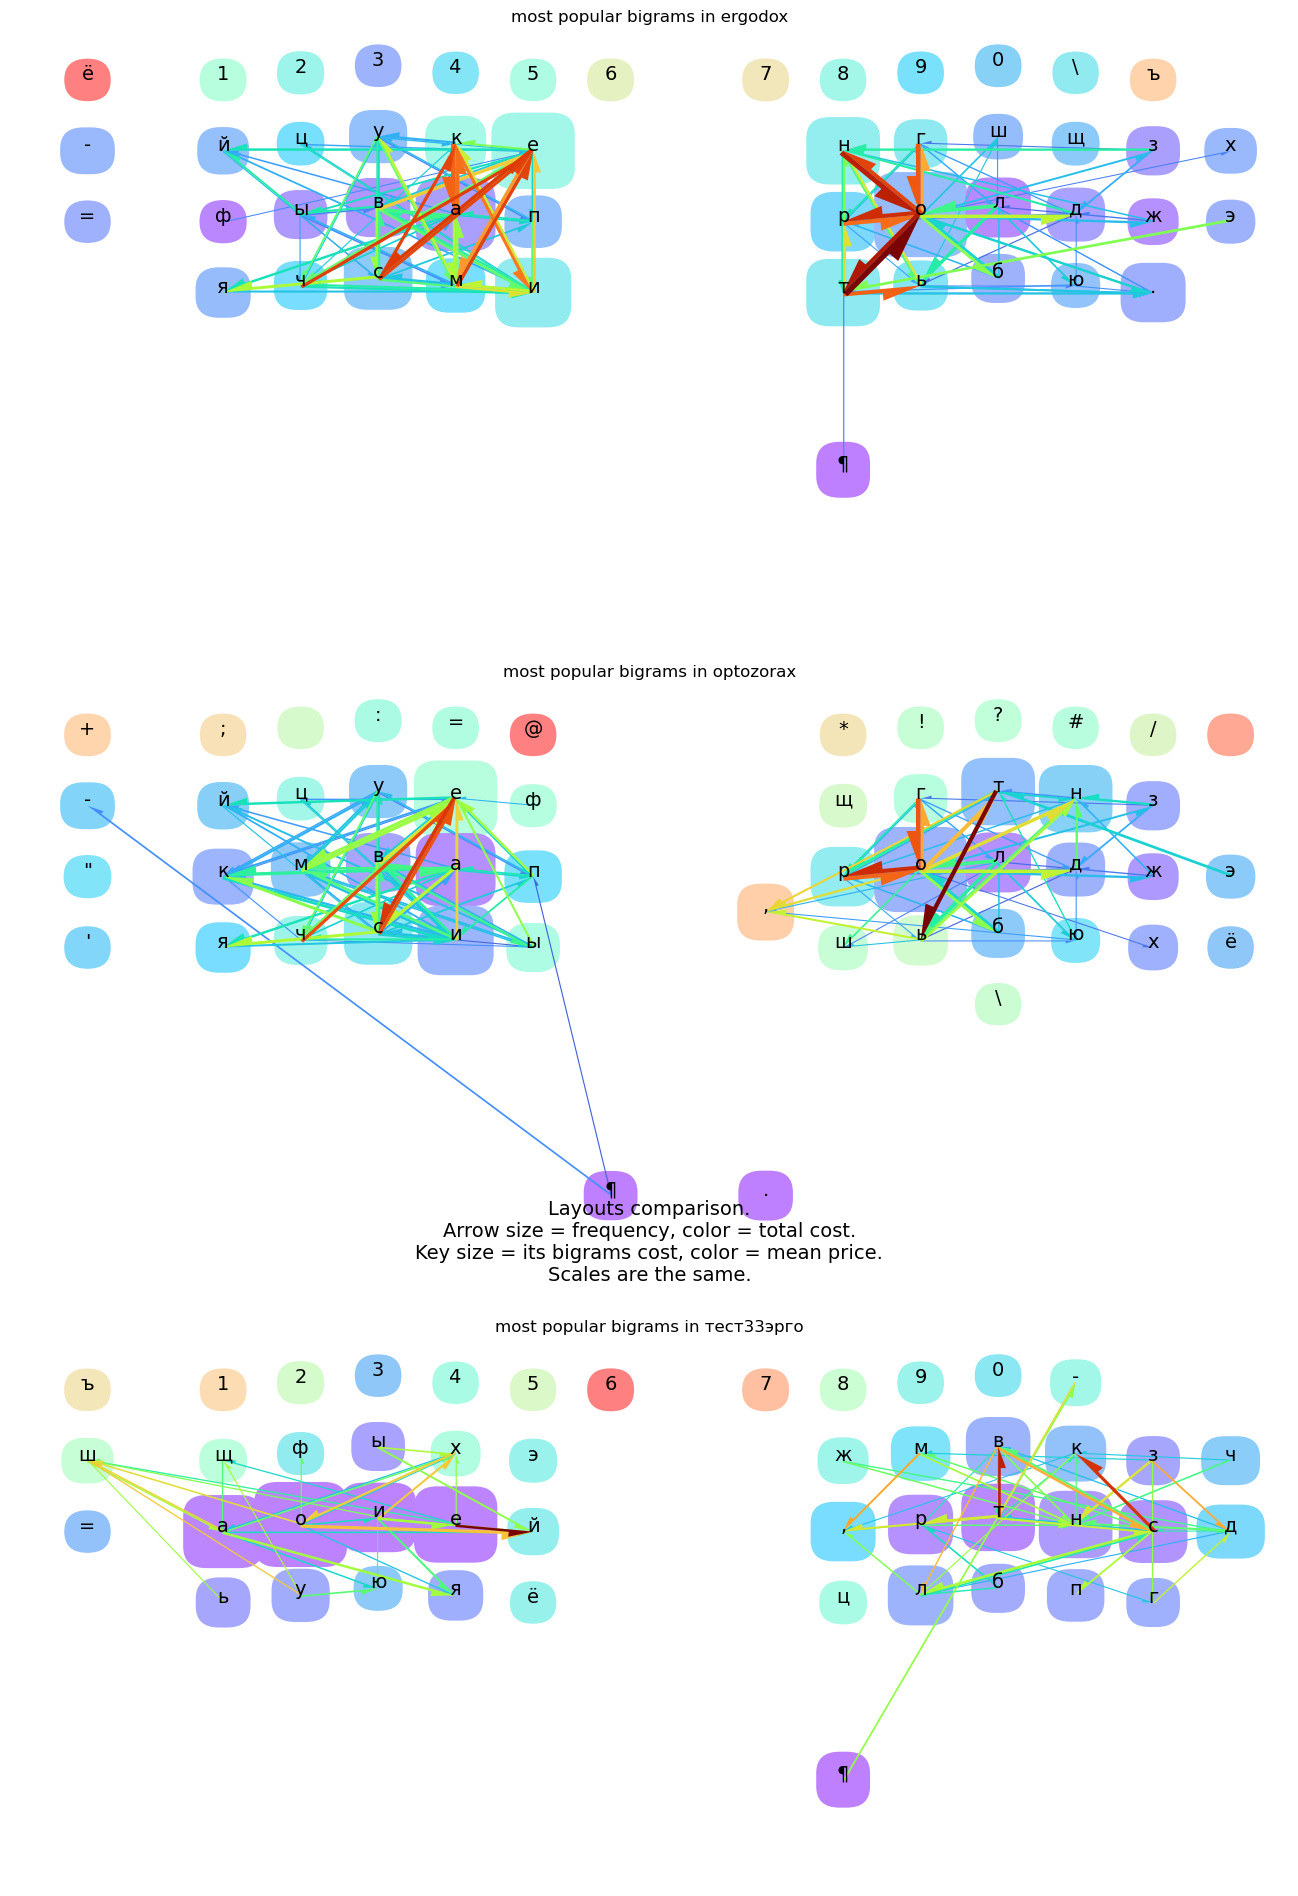

In [32]:
results['ergodox'].combomap(results['optozorax'], results['тест33эрго'])

As we can see in the map above, йцукен on Ergodox is harder in most keys. Let's see what letters were improved actually:

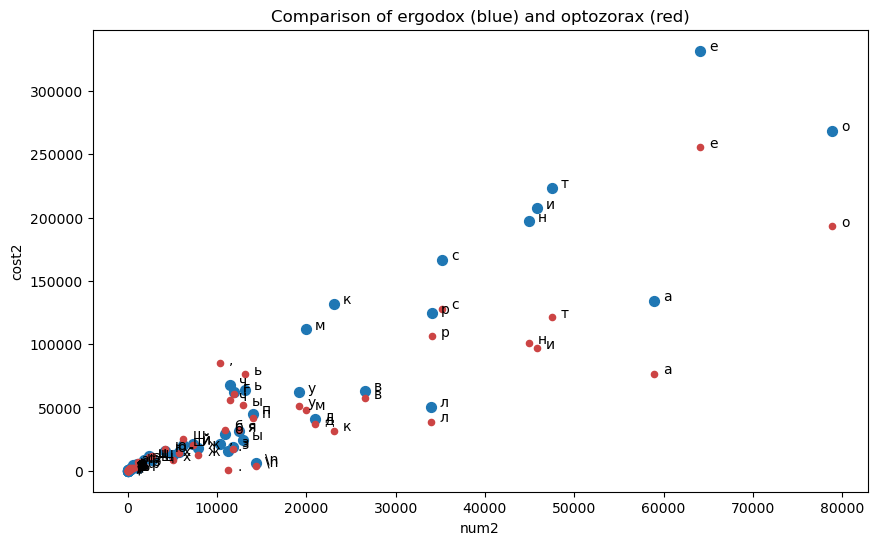

In [33]:
results['ergodox'].combochart(results['optozorax'])

But you may notice that Optozorax' layout is actually a modest modification of the standard ЙЦУКЕН. How far can we improve it? I've simply translated my test28, moving the rightmost letter Ж to the left side, and slash to up-right corner. The result scores 2.5 times better.

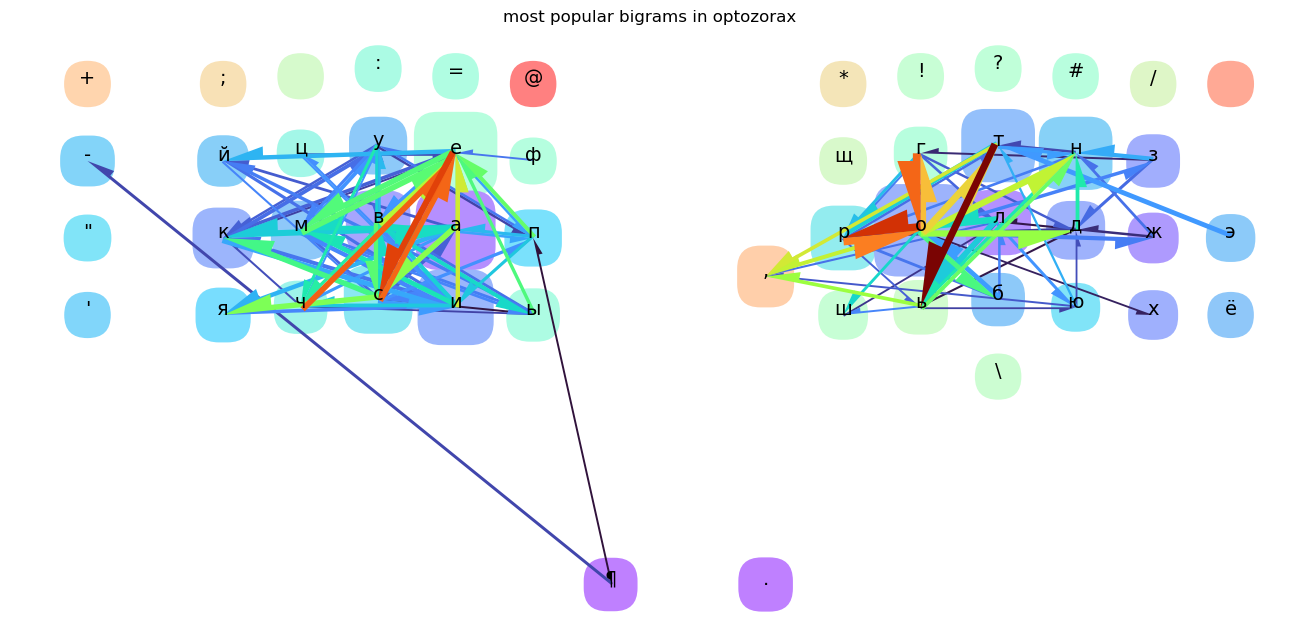

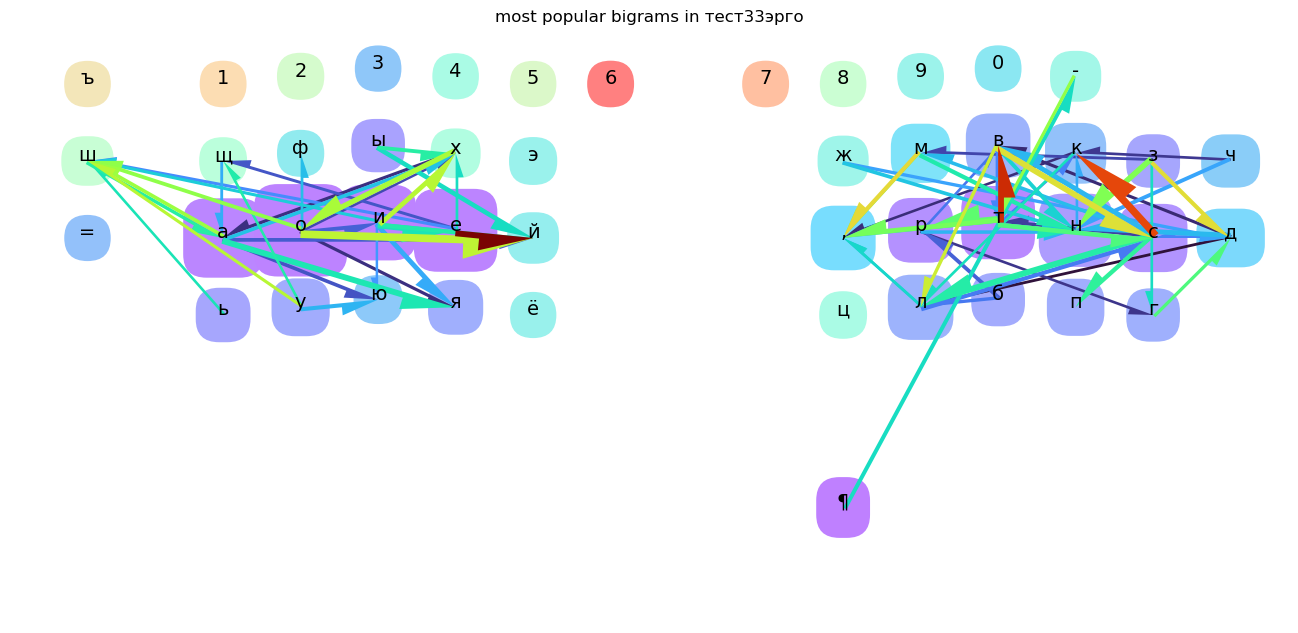

In [34]:
results['optozorax'].display('arrows')
results['тест33эрго'].display('arrows')


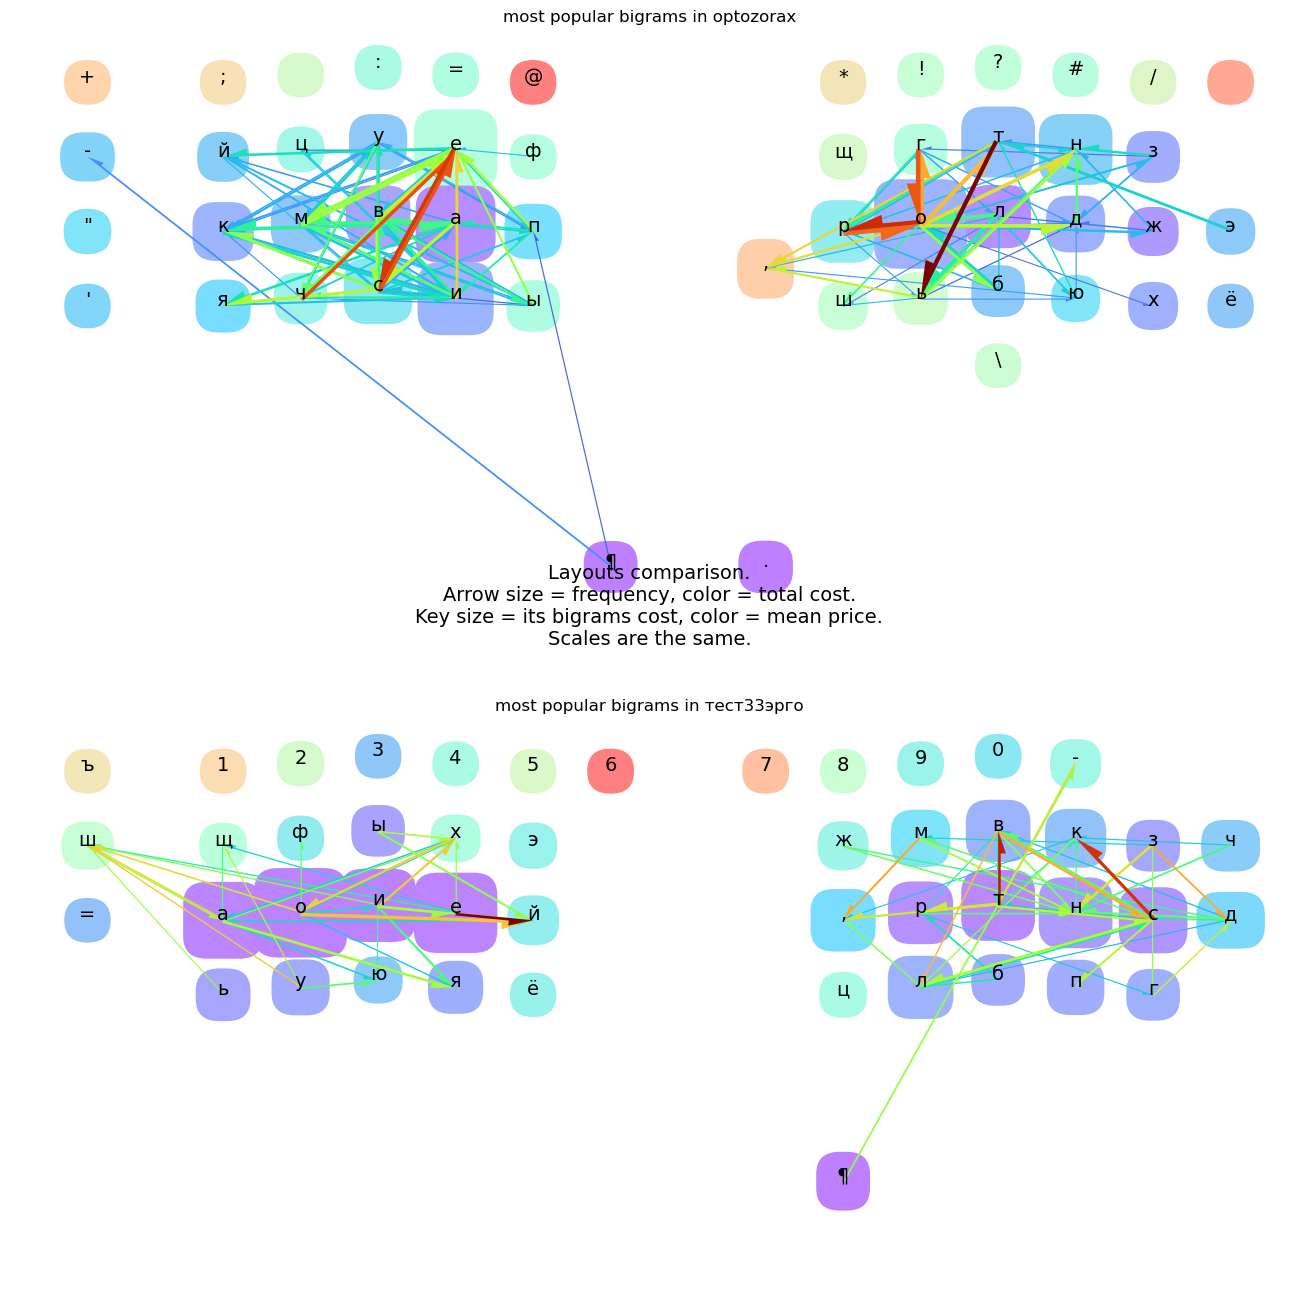

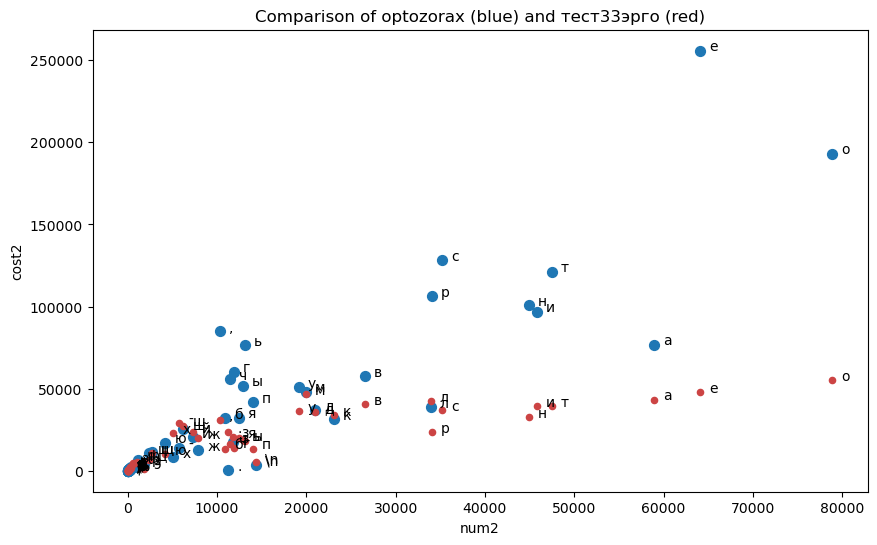

In [35]:
results['optozorax'].combomap(results['тест33эрго'])
results['optozorax'].combochart(results['тест33эрго'])

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

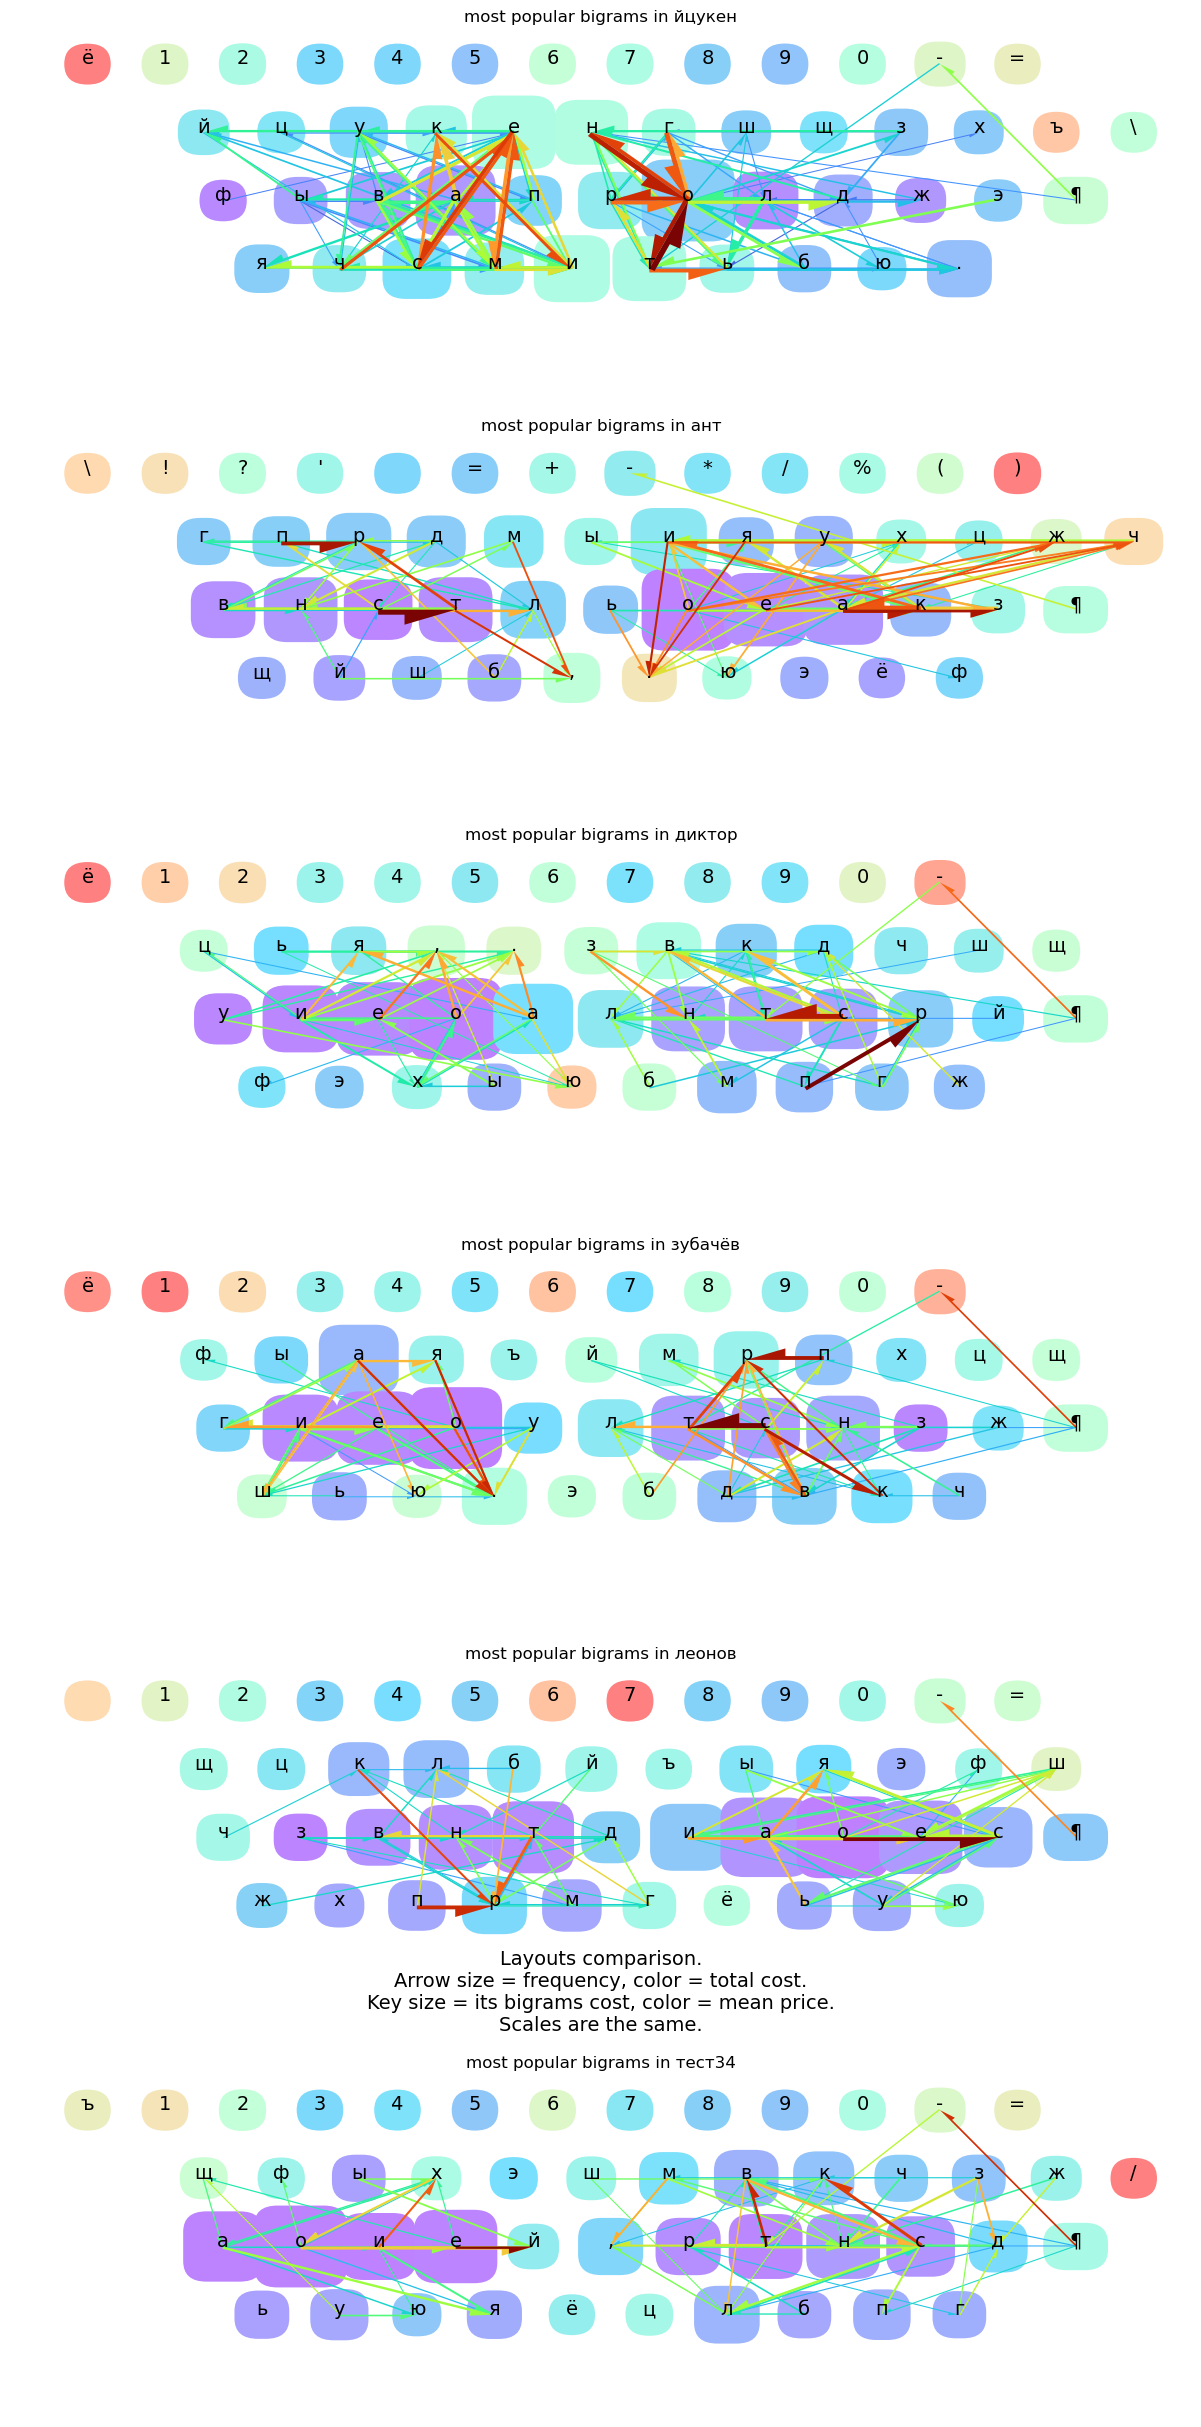

In [36]:
r = results
r['йцукен'].combomap(r['ант'], r['диктор'], r['зубачёв'], r['леонов'], r['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

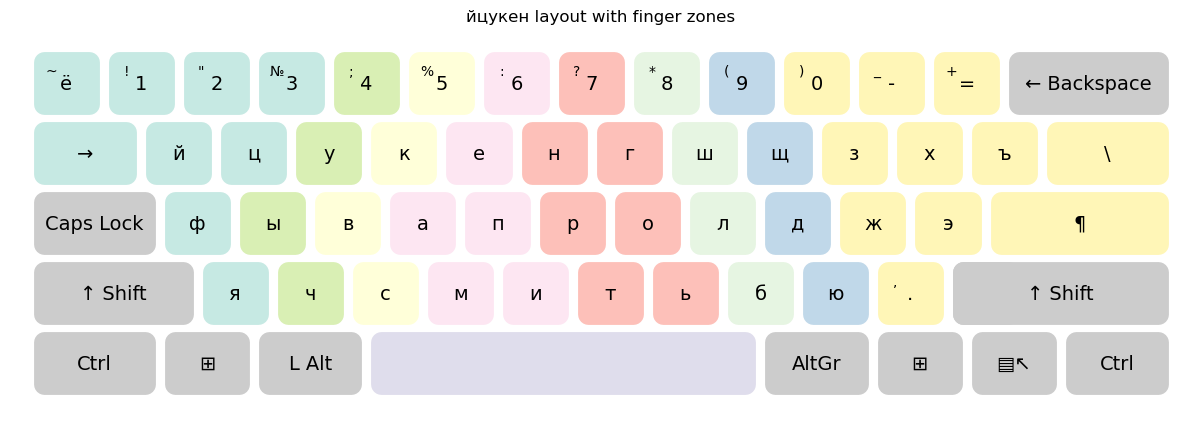

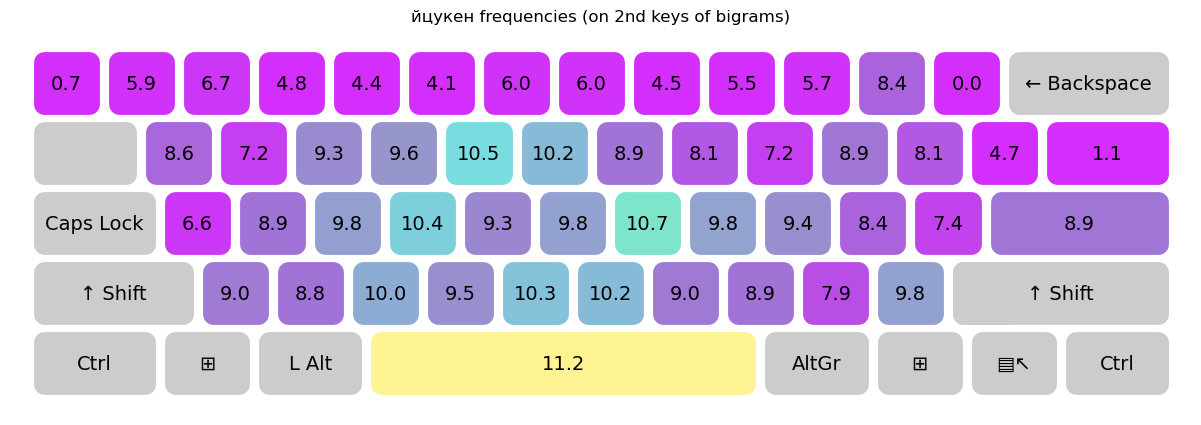

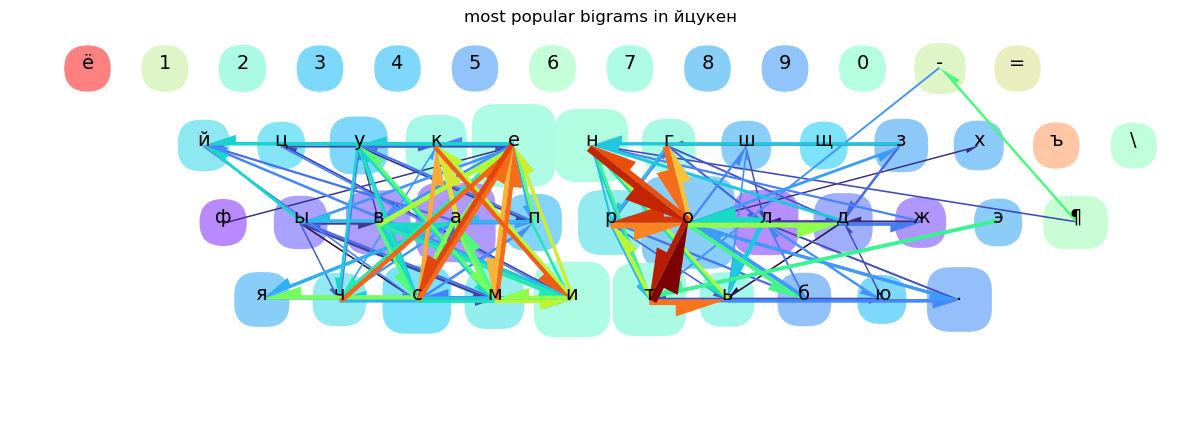

In [37]:
results['йцукен'].display('layout', 'num', 'arrows')

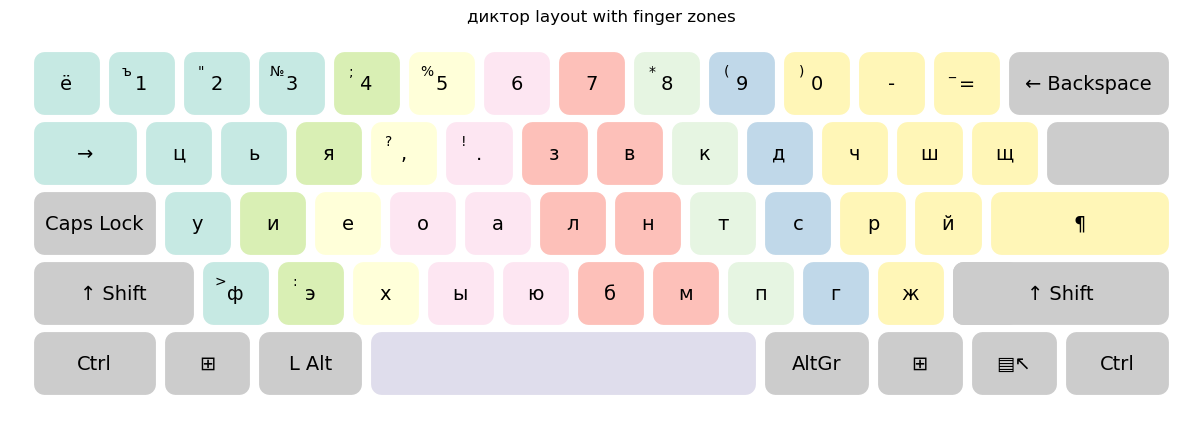

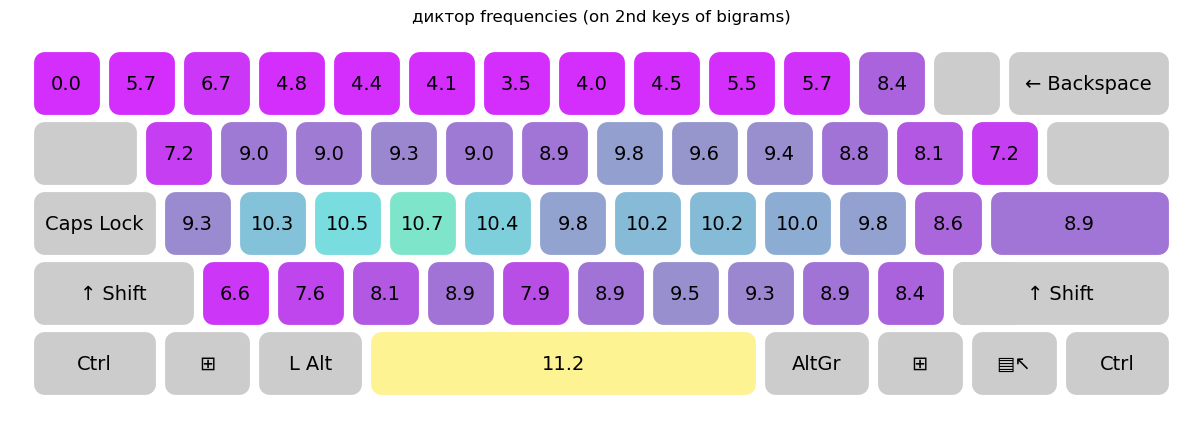

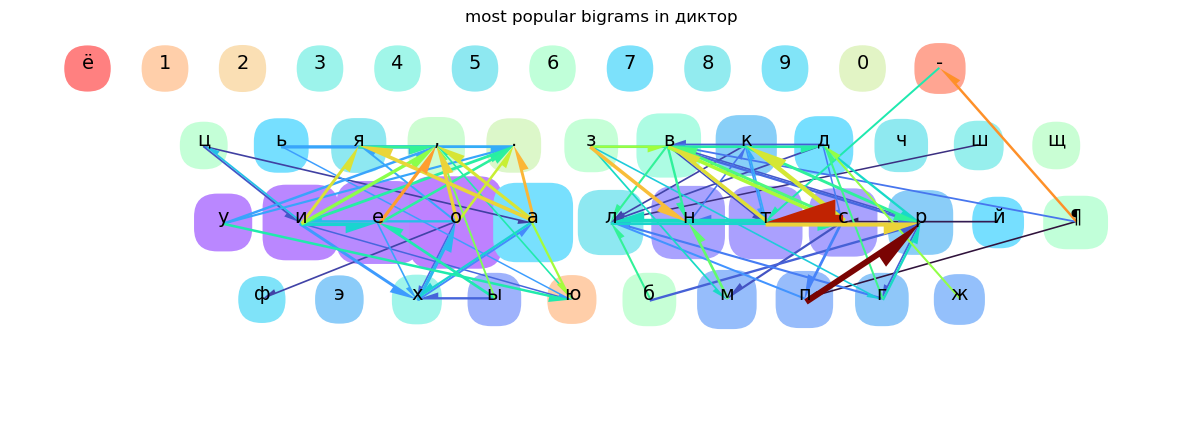

In [38]:
results['диктор'].display('layout', 'num', 'arrows')

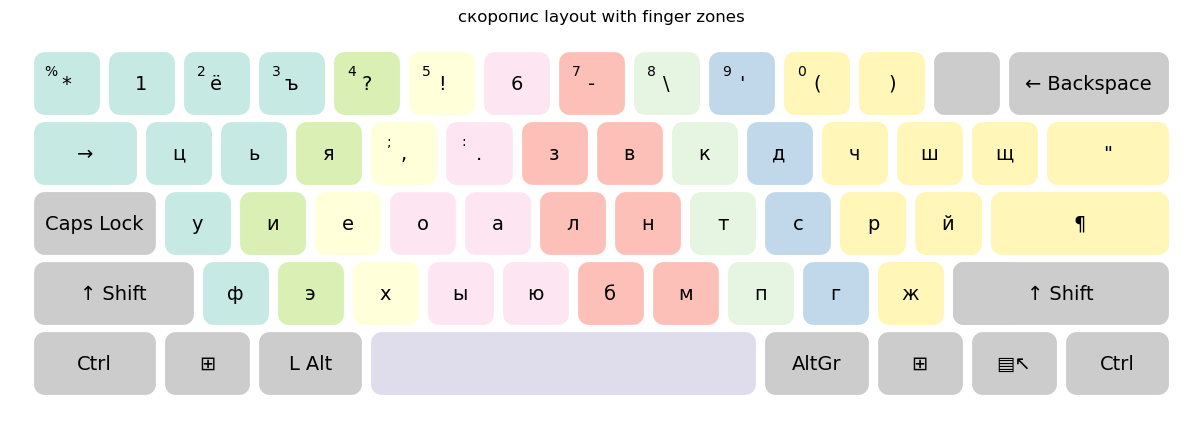

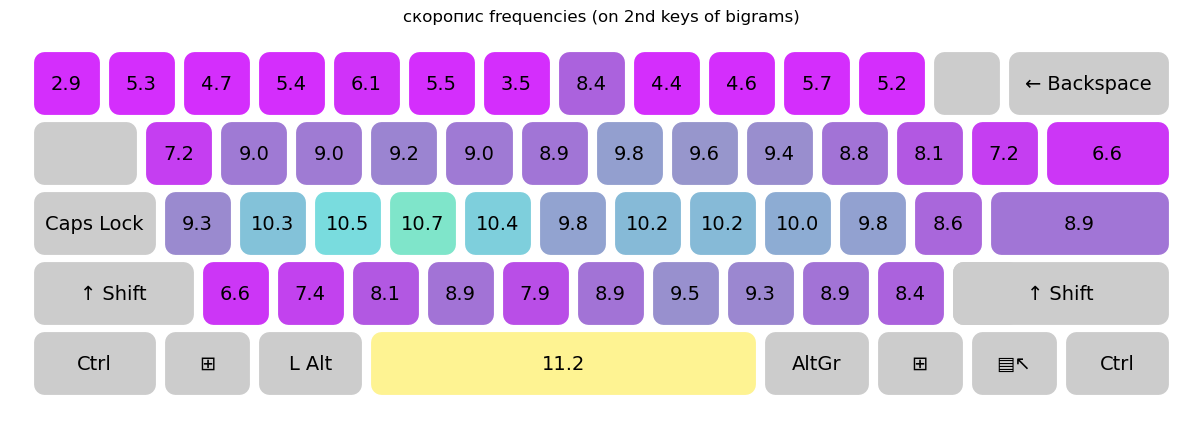

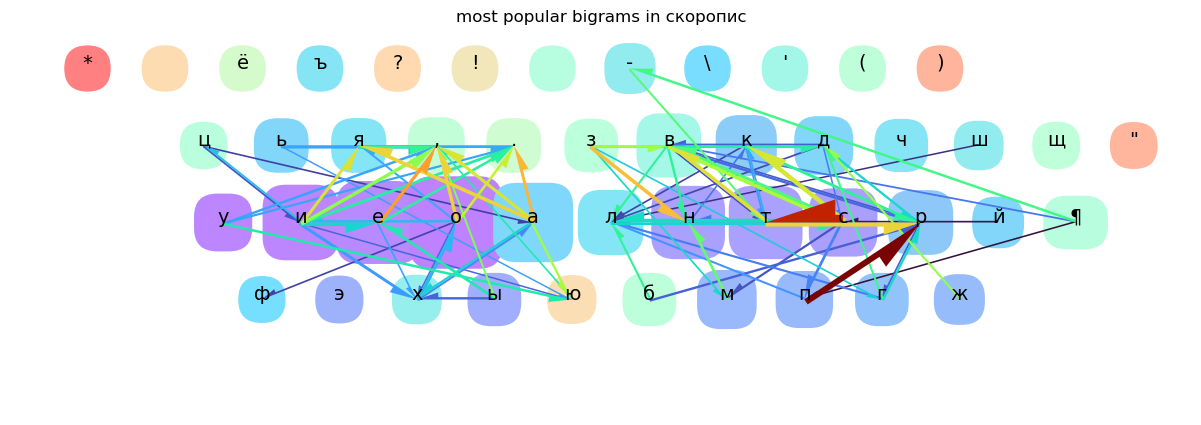

In [39]:
results['скоропис'].display('layout', 'num', 'arrows')

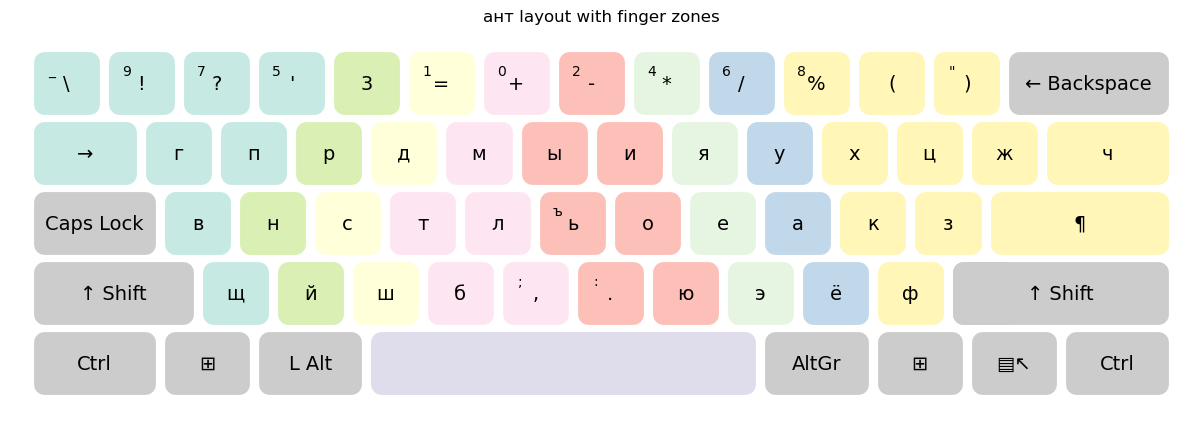

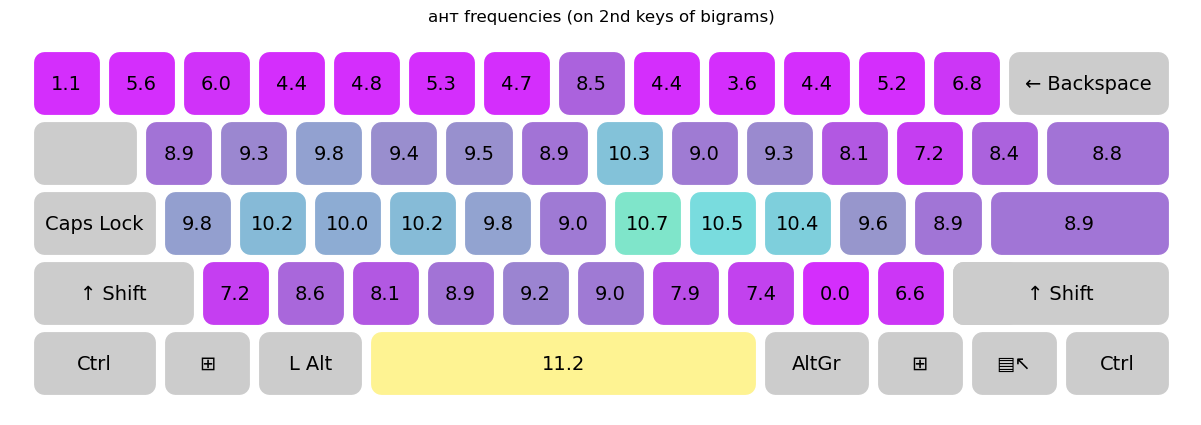

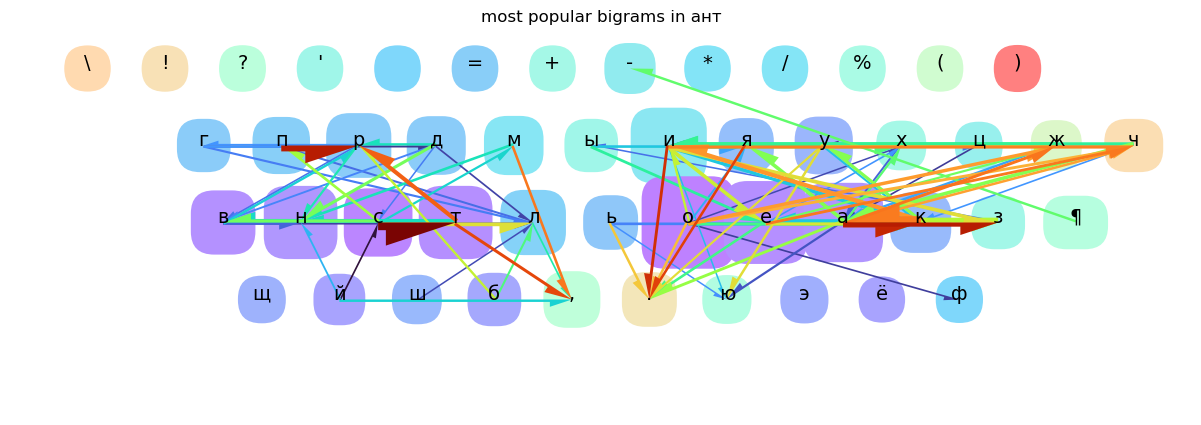

In [40]:
results['ант'].display('layout', 'num', 'arrows')

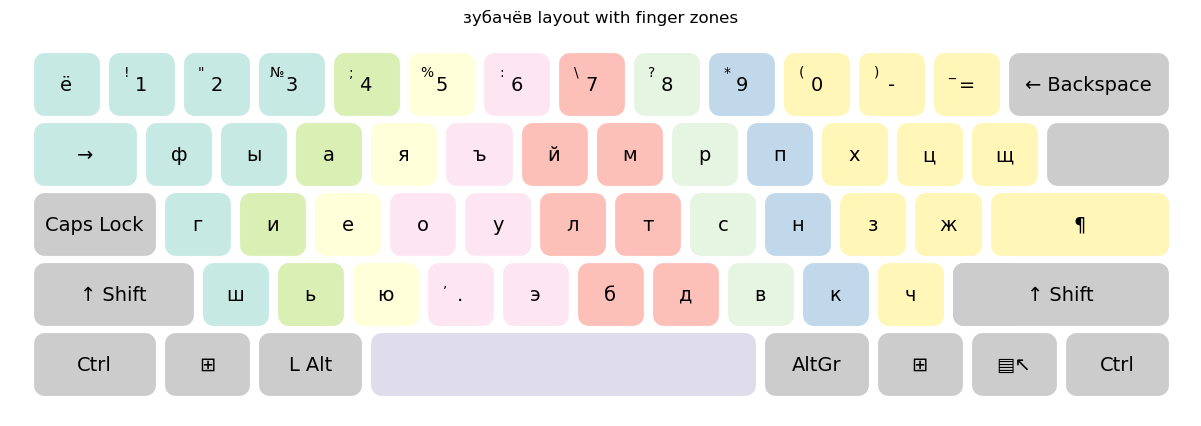

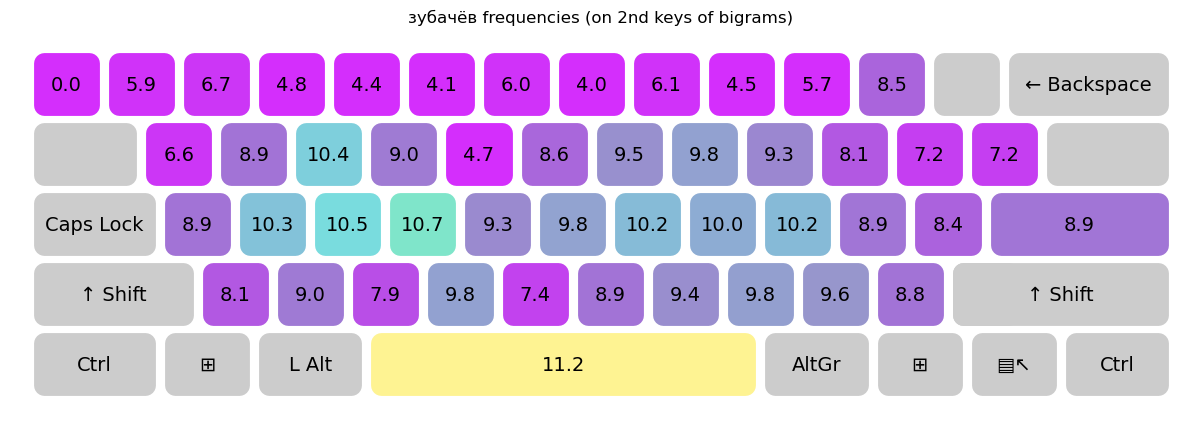

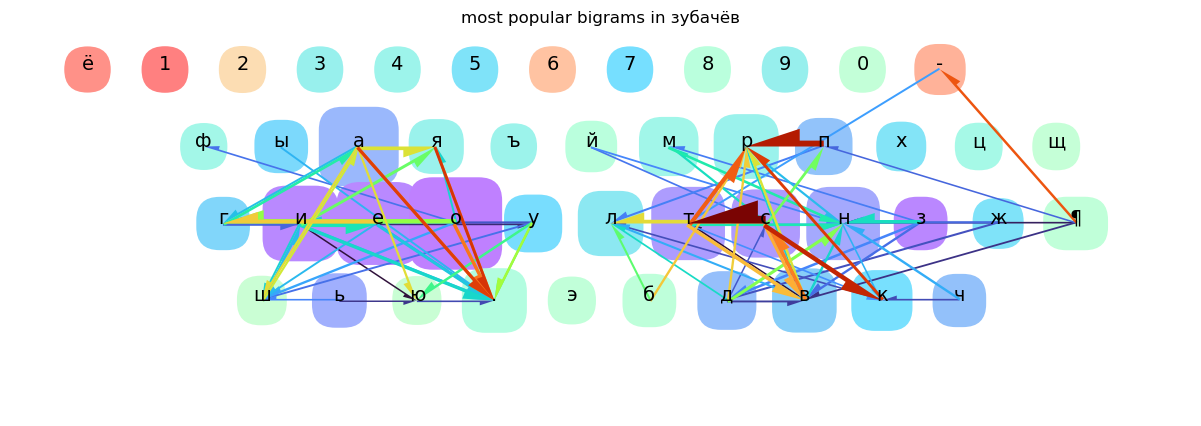

In [41]:
results['зубачёв'].display('layout', 'num', 'arrows')

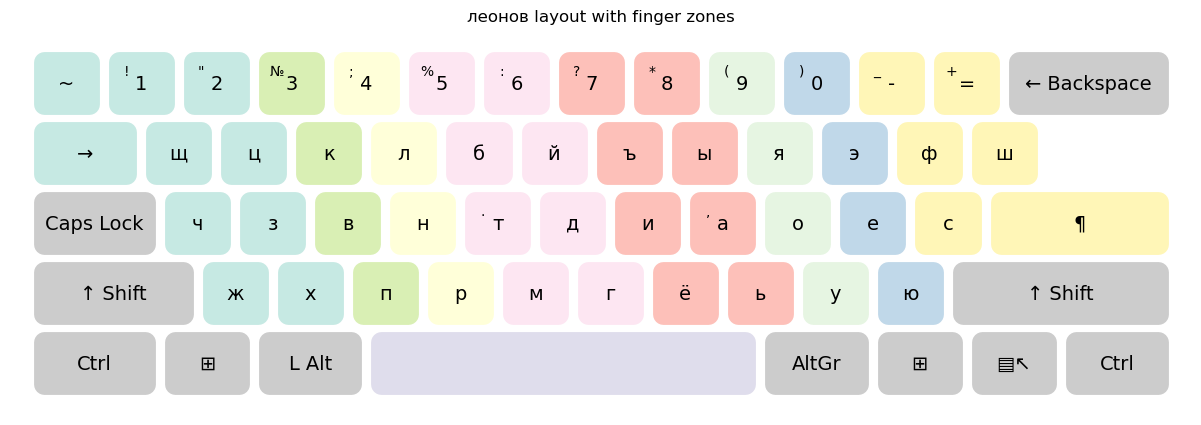

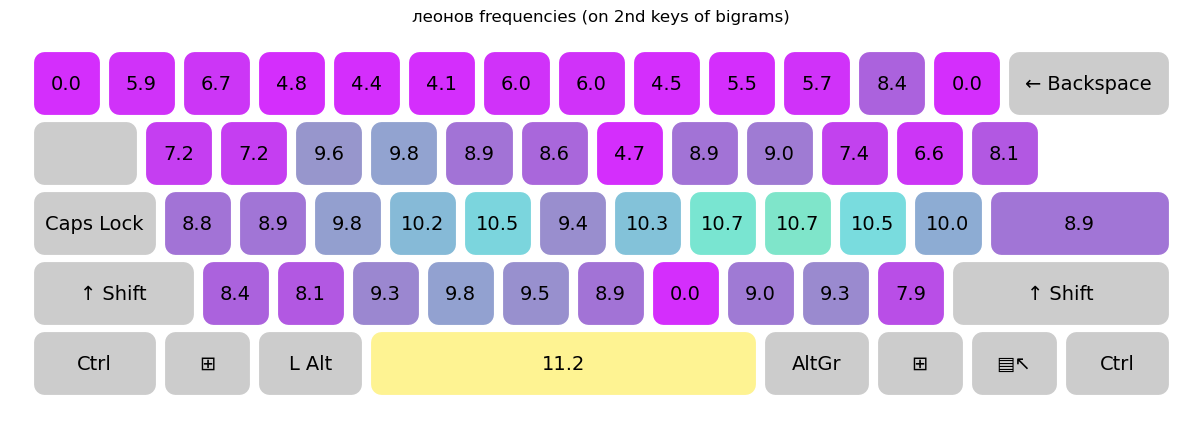

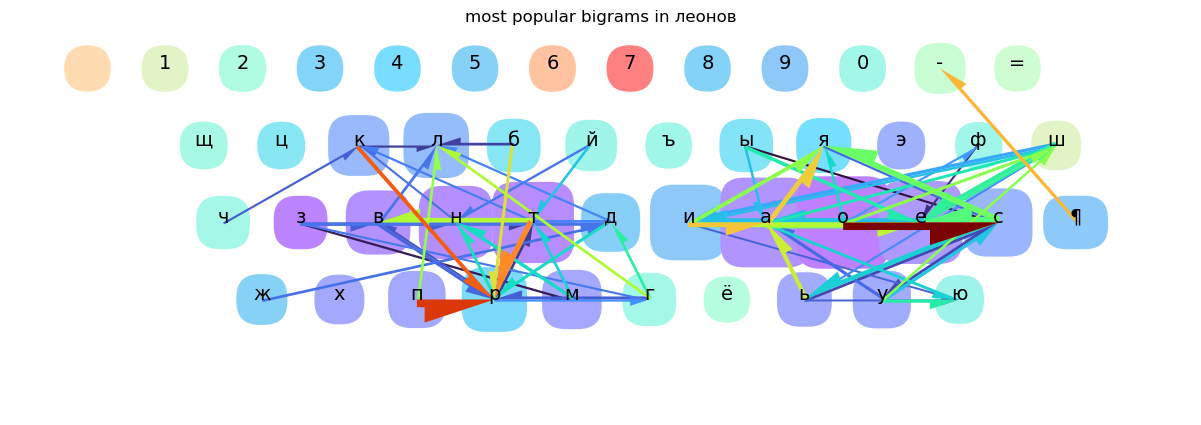

In [42]:
results['леонов'].display('layout', 'num', 'arrows')

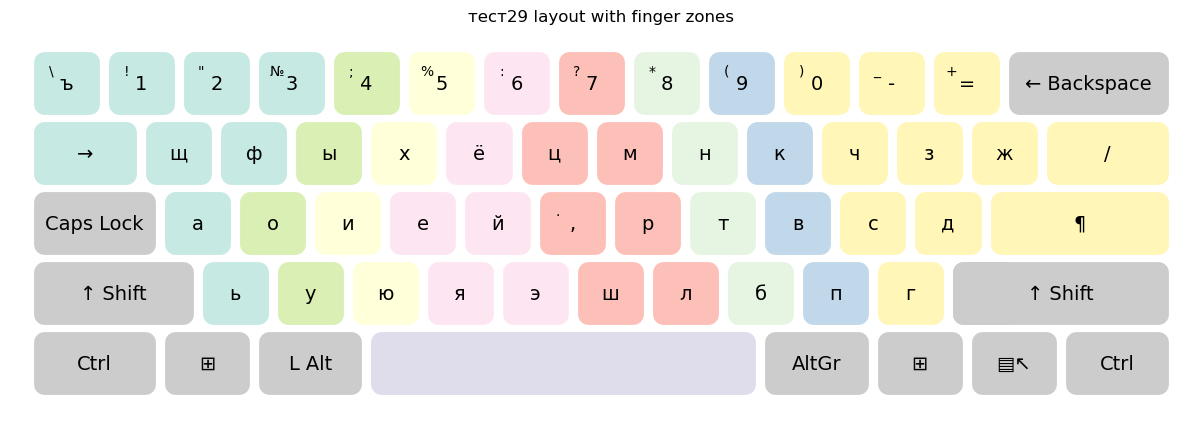

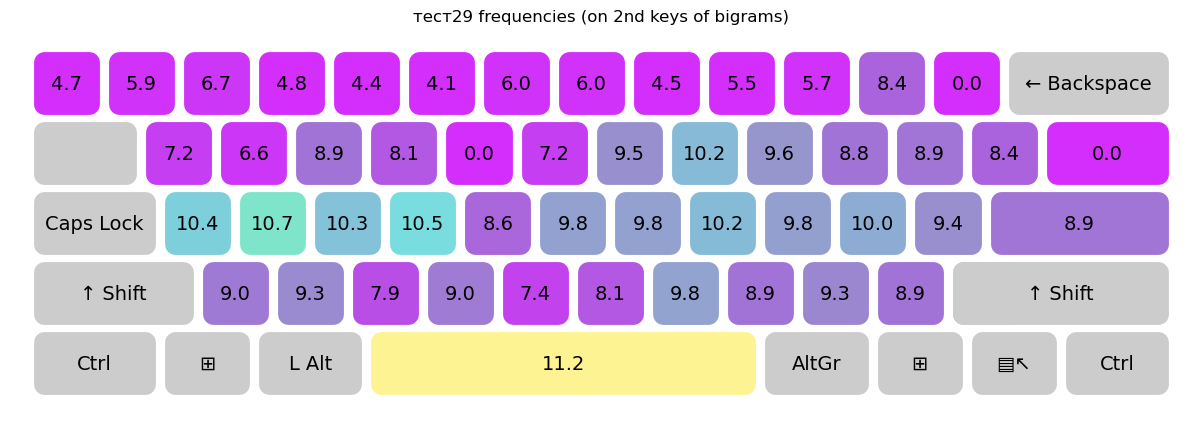

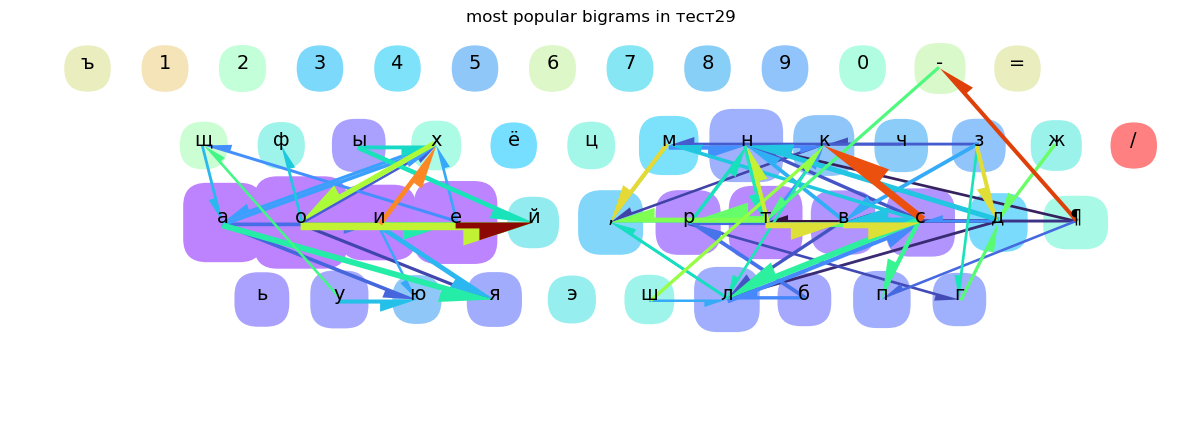

In [43]:
results['тест29'].display('layout', 'num', 'arrows')

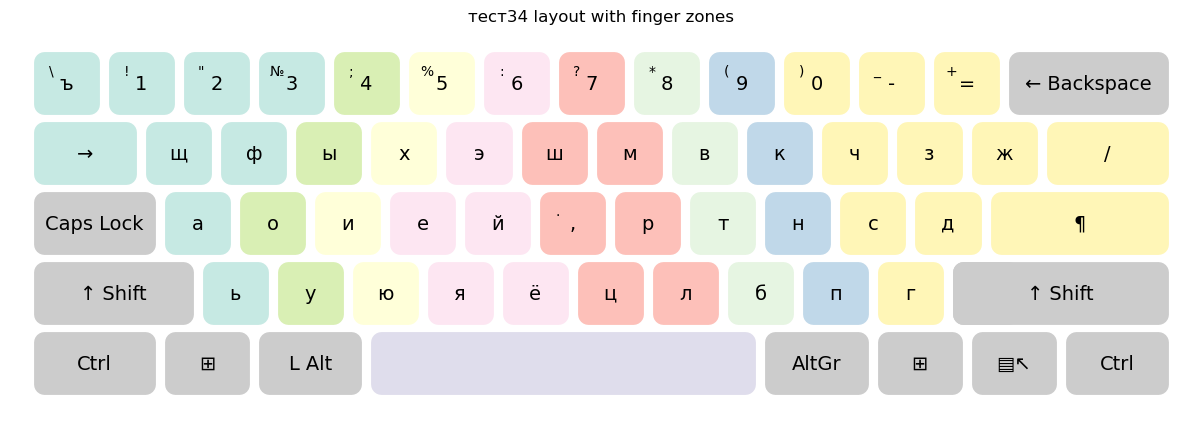

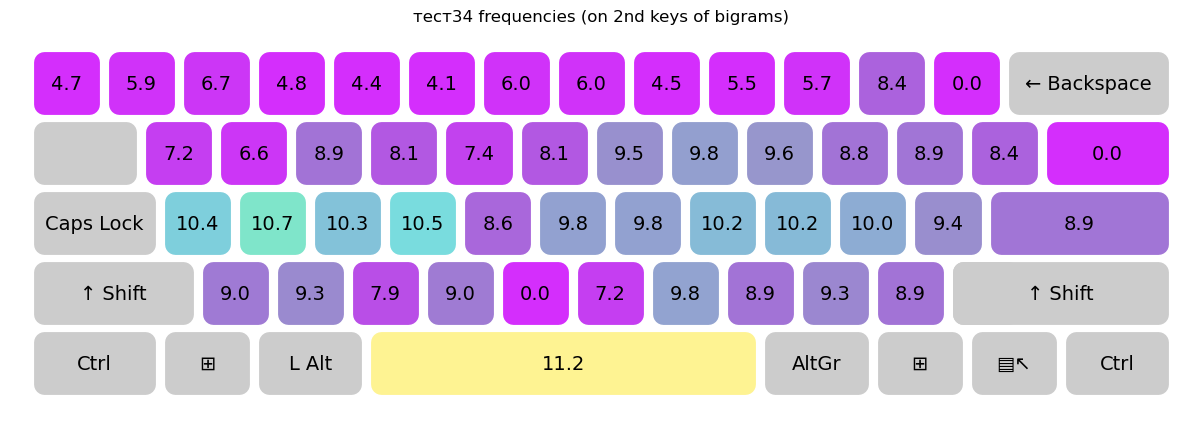

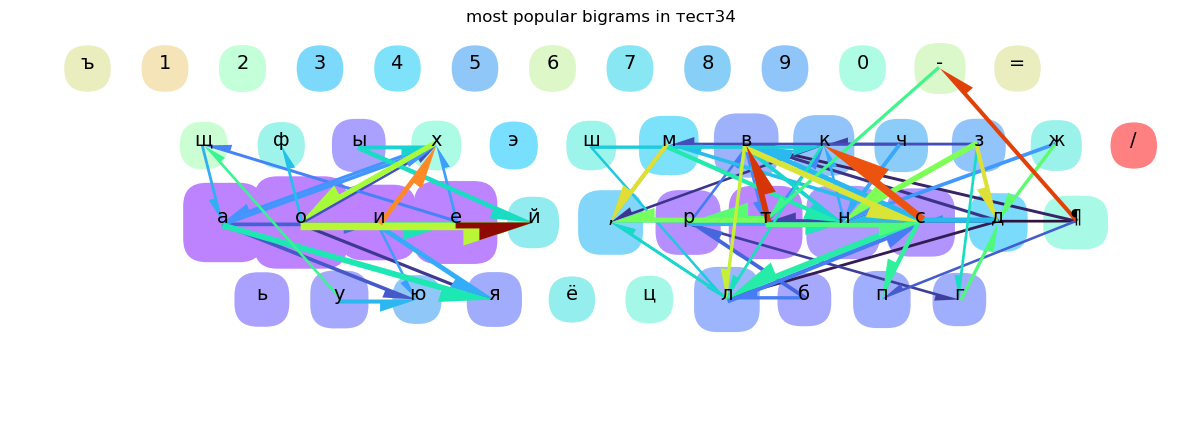

In [44]:
results['тест34'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [45]:
r = compare(results, 'леонов', 'тест32')
r.head(30)

bigram   num                     category_old  price_old  cost_old  \
41       по  3978                     altern hands          0         0   
143      .¶  2835                     altern hands          2      5670   
32       ¶¶  3769                         same key          2      7538   
106      ⌴в  6392                        space bar          0         0   
95       хо   954                     altern hands          0         0   
59       ск  1841                     altern hands          1      1841   
98       ей  1219                     altern hands          4      4876   
134      вс  1158                     altern hands          0         0   
176      ⌴э  1457                        space bar          1      1457   
100      ⌴з  2082                        space bar          0         0   
174      па   643                     altern hands          0         0   
377      зд   589      in, over 1 finger, same row          2      1178   
42       ов  3474                     altern hands          0         0   
259      тв  1155             out, over one finger          4      4620   
1314     --  1687                         same key          4      6748   
88       зн  1115      in, over 1 finger, same row          0         0   
152      т,   817                     altern hands          0         0   
256      их   798                     altern hands          1       798   
220      аз  1594                     altern hands          0         0   
442      вл   391  in, adj finger, same or adj row          3      1173   
39       ть  3088                     altern hands          1      3088   
58       тс   735                     altern hands          0         0   
312      оп   588                     altern hands          1       588   
531      -т   353                     altern hands          0         0   
390      ⌴-  1382                        space bar          4      5528   
24       из  1281                     altern hands          0         0   
30       ия   810             out, over one finger          5      4050   
47       м,   599                     altern hands          0         0   
253      ап   399                     altern hands          1       399   
138      ль  2227                     altern hands          1      2227   

                         category_new  price_new  cost_new  delta  
41            pinky -> ring, next row          3     11934  11934  
143                    index -> pinky          6     17010  11340  
32                           same key          4     15076   7538  
106                         space bar          1      6392   6392  
95                same finger adj row          6      5724   5724  
59            pinky -> ring, next row          4      7364   5523  
98                same finger adj row          8      9752   4876  
134              out, over one finger          4      4632   4632  
176                         space bar          4      5828   4371  
100                         space bar          2      4164   4164  
174               same finger adj row          6      3858   3858  
377               same finger adj row          8      4712   3534  
42                       altern hands          1      3474   3474  
259               same finger adj row          7      8085   3465  
1314                         same key          6     10122   3374  
88            pinky -> ring, next row          3      3345   3345  
152   in, adj finger, same or adj row          4      3268   3268  
256              out, over one finger          5      3990   3192  
220                      altern hands          2      3188   3188  
442               adj finger over row         11      4301   3128  
39                       altern hands          2      6176   3088  
58               out, over one finger          4      2940   2940  
312           ring -> pinky, next row          6      3528   2940  
531         over 1 finger, over 1 row          

In [46]:
r.tail(30)

bigram   num                     category_old  price_old  cost_old  \
70      об  1515                     altern hands          3      4545   
159     ше  1015          pinky -> ring, next row          3      3045   
60      ки  1658                     altern hands          2      3316   
7       ор  3337                     altern hands          1      3337   
221     ь,   850              same finger adj row          6      5100   
135     се  1715  in, adj finger, same or adj row          2      3430   
230     а,   924              same finger adj row          6      5544   
580     пл   376              adj finger over row         11      4136   
223     ас  1893                   index -> pinky          2      3786   
166     ти  1970                     altern hands          2      3940   
175     ае  1013             out, over one finger          4      4052   
209     ег  1360                     altern hands          4      5440   
154     ой  2056                     altern hands          4      8224   
82      и,  1043              same finger adj row          6      6258   
157     гл   418              adj finger over row         11      4598   
114     тр  1520             out, over one finger          5      7600   
63      ⌴ч  2361                        space bar          4      9444   
302     ое  1222             out, over one finger          4      4888   
71      бр   504              adj finger over row         11      5544   
11      ри  2520                     altern hands          2      5040   
156     ог  1841                     altern hands          4      7364   
77      ⌴г  1914                        space bar          4      7656   
96      ли  2881                     altern hands          2      5762   
83      ⌴б  3171                        space bar          3      9513   
29      ни  3789                     altern hands          2      7578   
430     кр   771              adj finger over row         11      8481   
37      ес  2283             out, over one finger          4      9132   
10      пр  3190  in, adj finger, same or adj row          3      9570   
23      ⌴и  5249                        space bar          2     10498   
14      ос  3042             out, over one finger          4     12168   

                        category_new  price_new  cost_new  delta  
70                      altern hands          1      1515  -3030  
159                     altern hands          0         0  -3045  
60                      altern hands          0         0  -3316  
7                       altern hands          0         0  -3337  
221                     altern hands          2      1700  -3400  
135                     altern hands          0         0  -3430  
230                     altern hands          2      1848  -3696  
580                     altern hands          1       376  -3760  
223                     altern hands          0         0  -3786  
166                     altern hands          0         0  -3940  
175      in, over 1 finger, same row          0         0  -4052  
209                     altern hands          1      1360  -4080  
154      in, over 1 finger, same row          2      4112  -4112  
82                      altern hands          2      2086  -4172  
157      in, over 1 finger, same row          1       418  -4180  
114  in, adj finger, same or adj row          2      3040  -4560  
63                         space bar          2      4722  -4722  
302      in, over 1 finger, same row          0         0  -4888  
71        in, over 1 finger, adj row          1       504  -5040  
11                      altern hands          0         0  -5040  
156                     altern hands          1      1841  -5523  
77                         space bar          1      1914  -5742  
96                      altern hands          0         0  -5762  
83                         space bar          1      3171  -6342  
29                      altern han

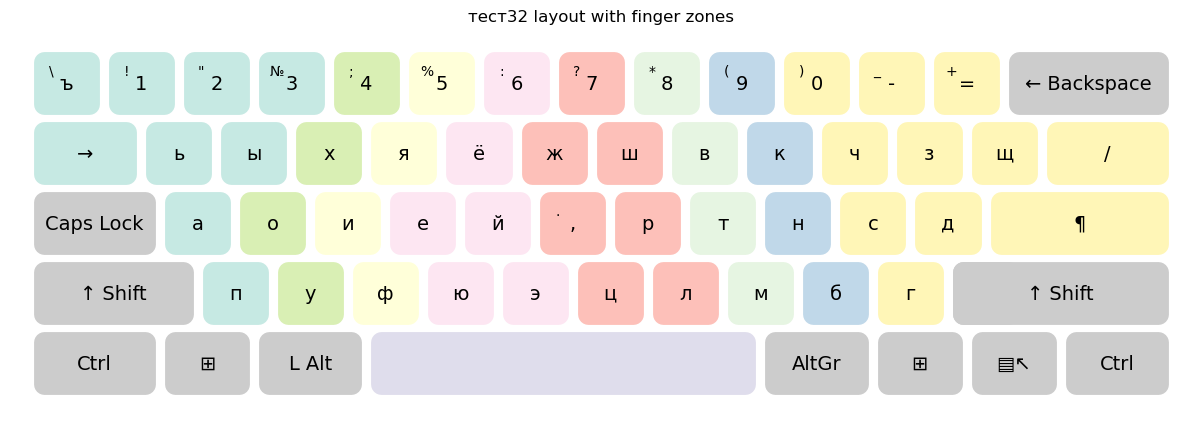

In [47]:
results['тест32'].layout.display()